In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import cf_xarray as cfxr

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats
from datetime import timedelta

import seaborn as sns
import matplotlib as mpl


In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

### Notes:

GFDL: 1pct and esm pi-control start from year 0001

UKESM1: 1pct starts in 1850 and pi-control starts in 1960, move 1pct to start in 1960

MIROC: both start from 1850

NORESM2: 1pct from 0001 pi-control from 1600-- move 1pct to 1600

ACCESS: 1pct and pi-control from 0101

CANESM5_r1p2: 1pct 1850, pi-control 5550, move 1pct to 5550


In [3]:
model_run_pulse_dict = utils.model_run_pulse_dict
model_run_1pct_dict = utils.model_run_1pct_dict
model_run_control_dict = utils.model_run_picontrol_dict
model_run_cdr_pulse_dict = utils.model_run_cdr_pulse_dict


In [4]:
model_color = utils.model_color
type_color = utils.type_color

In [5]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)

In [6]:
A = utils.find_area(ds_out)

In [7]:
tas_co2_1pct = {}
tas_co2_pictrl = {}

for m in model_run_1pct_dict.keys():
    print(m)
    print('tas')
    tas_co2_1pct[m] = xr.open_mfdataset(f'cmip6_data/tas_Amon_{model_run_1pct_dict[m]}',  use_cftime=True) #kg/m2/s
    lat_corners = cfxr.bounds_to_vertices(tas_co2_1pct[m].isel(time = 0)['lat_bnds'], "bnds", order=None)
    lon_corners = cfxr.bounds_to_vertices(tas_co2_1pct[m].isel(time = 0)['lon_bnds'], "bnds", order=None)
    tas_co2_1pct[m] = tas_co2_1pct[m].assign(lon_b=lon_corners, lat_b=lat_corners)
    tas_co2_1pct[m] = utils._regrid_ds(tas_co2_1pct[m], ds_out)
for m in model_run_control_dict.keys():
    print(m)
    print('tas')
    tas_co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/tas_Amon_{model_run_control_dict[m]}',  use_cftime=True) #kg/m2/s
    lat_corners = cfxr.bounds_to_vertices(tas_co2_pictrl[m].isel(time = 0)['lat_bnds'], "bnds", order=None)
    lon_corners = cfxr.bounds_to_vertices(tas_co2_pictrl[m].isel(time = 0)['lon_bnds'], "bnds", order=None)
    tas_co2_pictrl[m] = tas_co2_pictrl[m].assign(lon_b=lon_corners, lat_b=lat_corners)
    tas_co2_pictrl[m] = utils._regrid_ds(tas_co2_pictrl[m], ds_out)

## fix the times so that they line up according to the notes above
m = 'NORESM2'
tas_co2_pictrl[m]['time'] = tas_co2_pictrl[m]['time'] -timedelta(365*1599)

m = 'UKESM1_r1'
tas_co2_pictrl[m]['time'] = tas_co2_pictrl[m]['time'] - timedelta(360*110)

m = 'CANESM5_r1p2'
tas_co2_pictrl[m]['time'] = tas_co2_pictrl[m]['time']- timedelta(365*3700)

m = 'CANESM5_r1p1'
tas_co2_pictrl[m]['time'] = tas_co2_pictrl[m]['time']- timedelta(365*3351)


UKESM1_r1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


UKESM1_r2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


UKESM1_r3
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


UKESM1_r4
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


MIROC
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


NORESM2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


ACCESS
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


GFDL
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r1p2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r2p2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r3p2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r1p1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r2p1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r3p1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


UKESM1_r1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


MIROC
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


NORESM2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


ACCESS
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


GFDL
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r1p2
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CANESM5_r1p1
tas


/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [8]:
dif = {}
for m1 in model_run_1pct_dict.keys():
    print(m1)
    if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
        m2 = 'UKESM1_r1'
    elif m1 == 'CANESM5_r1p1' or m1 == 'CANESM5_r2p1' or m1 == 'CANESM5_r3p1':
         m2 = 'CANESM5_r1p1'
    elif m1 == 'CANESM5_r1p2' or m1 == 'CANESM5_r2p2' or m1 == 'CANESM5_r3p2':
         m2 = 'CANESM5_r1p2'
    else:
        m2 = m1
    print(m1, m2)
    
    dif[m1] = tas_co2_1pct[m1] - tas_co2_pictrl[m2]
    times = pd.date_range('2000', periods=len(dif[m1]['time']), freq='MS')
    weights = times.shift(1, 'MS') - times
    weights = xr.DataArray(weights, [('time', dif[m1]['time'].values)]).astype('float')
    dif[m1] =  (dif[m1] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')

    #dif[m1] = dif[m1].groupby('time.year').mean()
    dif[m1]['year'] = range(len(dif[m1]['year']))

UKESM1_r1
UKESM1_r1 UKESM1_r1
UKESM1_r2
UKESM1_r2 UKESM1_r1
UKESM1_r3
UKESM1_r3 UKESM1_r1
UKESM1_r4
UKESM1_r4 UKESM1_r1
MIROC
MIROC MIROC
NORESM2
NORESM2 NORESM2
ACCESS
ACCESS ACCESS
GFDL
GFDL GFDL
CANESM5_r1p2
CANESM5_r1p2 CANESM5_r1p2
CANESM5_r2p2
CANESM5_r2p2 CANESM5_r1p2
CANESM5_r3p2
CANESM5_r3p2 CANESM5_r1p2
CANESM5_r1p1
CANESM5_r1p1 CANESM5_r1p1
CANESM5_r2p1
CANESM5_r2p1 CANESM5_r1p1
CANESM5_r3p1
CANESM5_r3p1 CANESM5_r1p1


In [9]:
for m in dif.keys():
    dif[m] = dif[m].drop('height')

In [10]:
ds_dif = xr.concat([dif[m] for m in dif.keys()], pd.Index([m for m in dif.keys()], name='model'), coords='minimal')


In [11]:
ds_dif = ds_dif.rename({'year':'s'})

## Import G

In [12]:
G_ds = xr.open_dataset('Outputs/G_ds.nc4')['__xarray_dataarray_variable__']
G_mean_ds = xr.open_dataset('Outputs/G_mean_ds.nc4')['__xarray_dataarray_variable__']

G_CDR_ds = xr.open_dataset('Outputs/G_cdr_ds.nc4')['__xarray_dataarray_variable__']
G_CDR_mean_ds = xr.open_dataset('Outputs/G_cdr_mean_ds.nc4')['__xarray_dataarray_variable__']

In [13]:
G_ds = xr.concat([G_ds, -G_CDR_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))
G_mean_ds = xr.concat([G_mean_ds, -G_CDR_mean_ds], pd.Index(['pulse','cdr'], name = 'pulse_type'))

In [14]:
G_ds.name = 'G[tas]'
G_mean_ds.name = 'G[tas]'

In [15]:
G_ds = G_ds.rename({'year':'s'})
G_mean_ds = G_mean_ds.rename({'year':'s'})

## Emissions profile

In [16]:
emis_profile = xr.open_dataset(f'1pct_emis_profile_full.nc4')
emis_profile = emis_profile.rename({'__xarray_dataarray_variable__':'emis'})

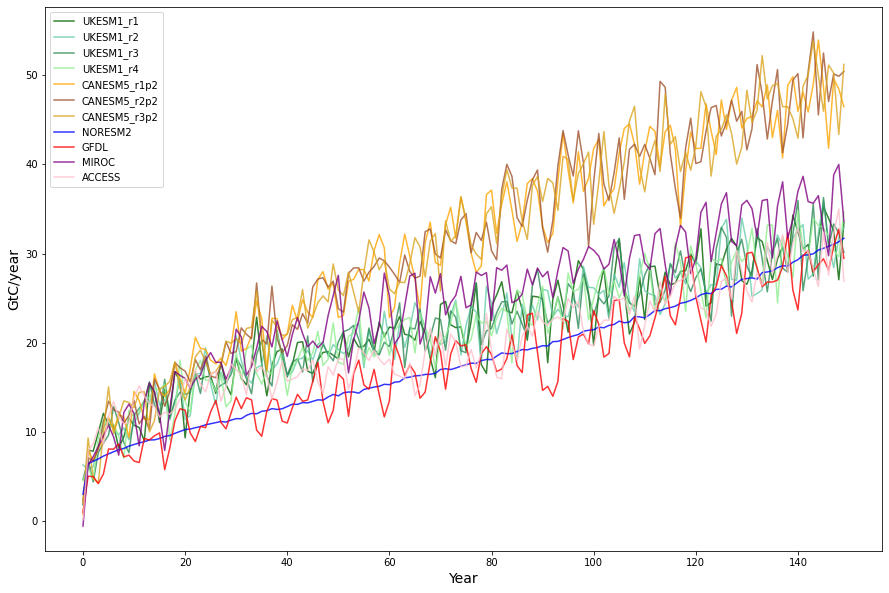

In [17]:
fig, ax = plt.subplots(figsize = [15,10])
for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2', 'NORESM2', 'GFDL', 'MIROC', 'ACCESS']:
    plt.plot(emis_profile.sel(model = m)['emis'], alpha = .8, label = f'{m}', color = model_color[m])
#plt.plot(emis_profile.mean(dim = 'model')['emis'], color = 'k', label = f'Model Mean')
plt.legend()
plt.xlabel('Year', fontsize = 14)
plt.ylabel('GtC/year', fontsize = 14)
plt.savefig('figures/1pct_increase/emis_profiles.png', bbox_inches = 'tight', dpi = 350)

## Global Mean Analysis

In [20]:
%%time
GF = G_ds.weighted(A).mean(dim = ['lat','lon'])

conv_1pct_mean = {}
for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
   'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2',]:
    conv_1pct_mean[m1] = {}
    print(m1)
    for t in ['pulse','cdr']:
        if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
            m2 = 'UKESM1_r1'
        else:
            m2 = m1
        print(m1, m2)
        conv_1pct_mean[m1][t] = signal.convolve( np.array(GF.sel(model = m2, pulse_type = t).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis']),'full')
        conv_1pct_mean[m1][t] = utils.np_to_xr_mean(conv_1pct_mean[m1][t], GF.sel(model = m2, pulse_type = t), emis_profile.sel(model = m1))


UKESM1_r1
UKESM1_r1 UKESM1_r1
UKESM1_r1 UKESM1_r1
UKESM1_r2
UKESM1_r2 UKESM1_r1
UKESM1_r2 UKESM1_r1
UKESM1_r3
UKESM1_r3 UKESM1_r1
UKESM1_r3 UKESM1_r1
UKESM1_r4
UKESM1_r4 UKESM1_r1
UKESM1_r4 UKESM1_r1
NORESM2
NORESM2 NORESM2
NORESM2 NORESM2
GFDL
GFDL GFDL
GFDL GFDL
MIROC
MIROC MIROC
MIROC MIROC
CANESM5_r1p2
CANESM5_r1p2 CANESM5_r1p2
CANESM5_r1p2 CANESM5_r1p2
CANESM5_r2p2
CANESM5_r2p2 CANESM5_r2p2
CANESM5_r2p2 CANESM5_r2p2
ACCESS
ACCESS ACCESS
ACCESS ACCESS
CANESM5_r3p2
CANESM5_r3p2 CANESM5_r3p2
CANESM5_r3p2 CANESM5_r3p2
CPU times: user 1.73 s, sys: 526 ms, total: 2.25 s
Wall time: 2.27 s


In [21]:
#convert to dataset

conv_1pct_dict = {}
for m in conv_1pct_mean.keys():
    conv_1pct_dict[m] = xr.concat([conv_1pct_mean[m][t] for t in conv_1pct_mean[m].keys()], pd.Index([t for t in conv_1pct_mean[m].keys()], name='pulse_type'), coords='minimal')
conv_1pct_mean_ds = xr.concat([conv_1pct_dict[m] for m in conv_1pct_dict.keys()], pd.Index([m for m in conv_1pct_dict.keys()], name='model'), coords='minimal')


In [22]:
#define our weights for models (grouping UKESM and CANESM realizations)
model_weights = {'UKESM1_r1': 0.25, 'UKESM1_r2': 0.25, 'UKESM1_r3': 0.25, 'UKESM1_r4': 0.25, 'NORESM2': 1, 'GFDL': 1,
       'MIROC': 1, 'ACCESS': 1,  'CANESM5_r2p2':1/3, 'CANESM5_r1p2':1/3, 'CANESM5_r3p2':1/3}
model_weights = xr.DataArray(
    data=list(model_weights.values()),
    dims=["model"],
    coords=dict(
        model=(["model"], list(model_weights.keys()))
    ),
    attrs=dict(
        description="weights for models"
    ),
)

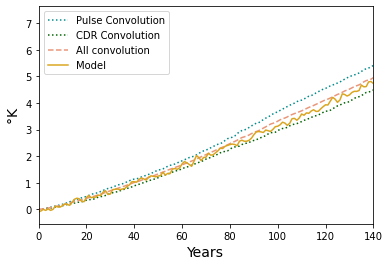

In [22]:
names = {'pulse':'Pulse Convolution', 'cdr':'CDR Convolution'}
for t in conv_1pct_mean_ds.pulse_type.values:
    plt.plot(conv_1pct_mean_ds.weighted(model_weights).mean(dim = 'model').sel(pulse_type = t), label = names[t], color = type_color[t], linestyle = ':')
plt.plot(conv_1pct_mean_ds.weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type'), label = f'All convolution', color = type_color['all'], linestyle = '--')
plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(model_weights).mean(dim = 'model').weighted(A).mean(dim = ['lat','lon'])['tas'], 
         label = 'Model', color = type_color['model'])
plt.legend()
plt.xlim(0,140)
plt.xlabel('Years', fontsize = 14)
plt.ylabel('$\degree$K', fontsize = 14)
plt.savefig('figures/1pct_increase/model_mean_convolution_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


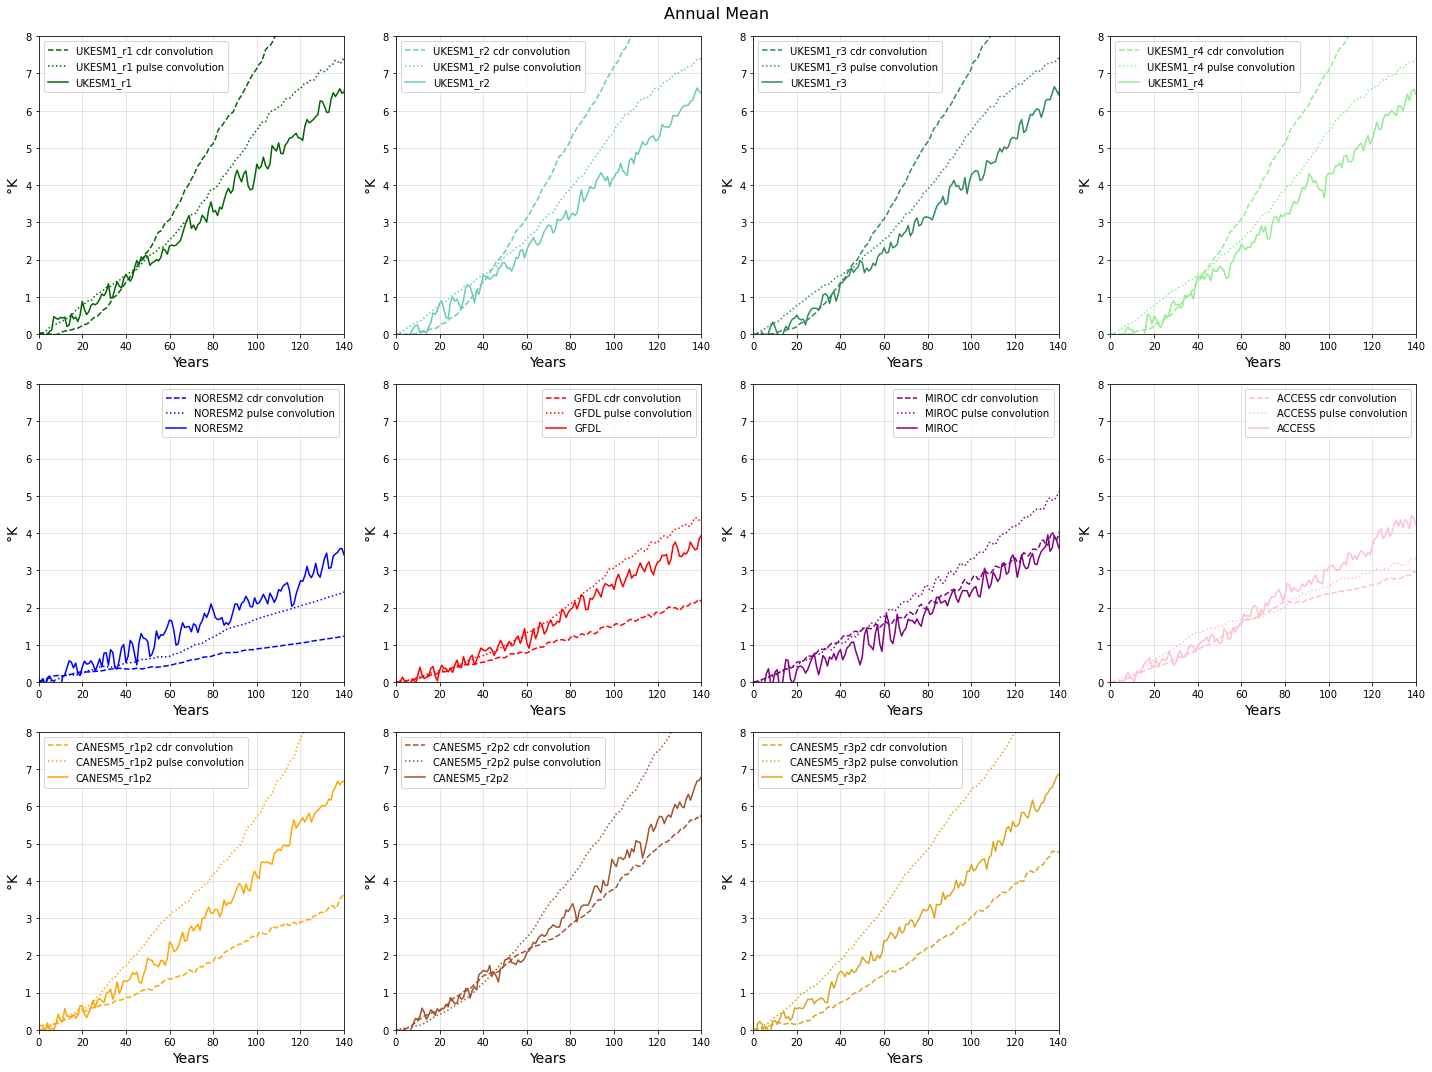

In [23]:
fig = plt.figure(figsize = [20,15])
plt.suptitle('Annual Mean', fontsize = 16, x = 0.5, y = 0.99)
for idx, m in enumerate(['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2', 'GFDL', 'MIROC', 'ACCESS', 'CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2']):
    ax = plt.subplot(3, 4, idx + 1)
    ax.plot(conv_1pct_mean_ds.sel(model = m, pulse_type = 'cdr'), label = f'{m} cdr convolution', color = model_color[m], linestyle = '--')
    ax.plot(conv_1pct_mean_ds.sel(model = m, pulse_type = 'pulse'), label = f'{m} pulse convolution', color = model_color[m], linestyle = ':')
    ax.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon']).sel(model = m)['tas'], label = m,color = model_color[m])

    plt.grid(alpha = 0.4)
    plt.legend()
    plt.xlim(0,140)
    plt.ylim(0,8)
    plt.xlabel('Years', fontsize = 14)
    plt.ylabel('$\degree$K', fontsize = 14)
    plt.tight_layout()
plt.savefig('figures/1pct_increase/1pct_vs_pulses_by_model_mean.png', dpi = 300, bbox_inches = 'tight')

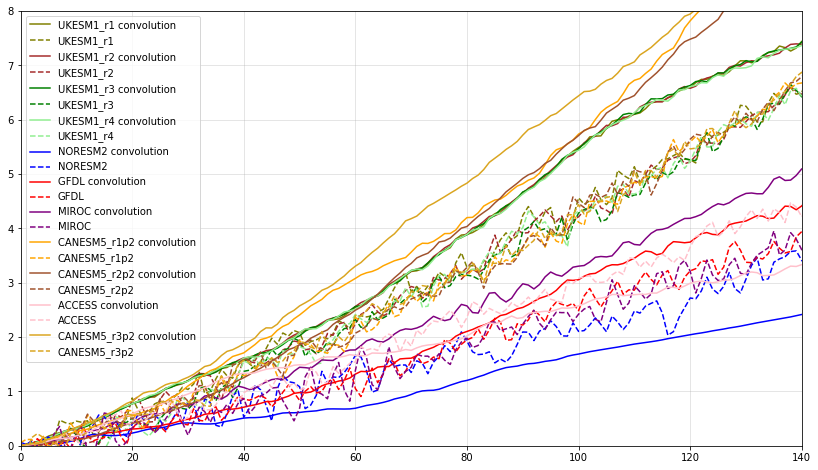

In [32]:
fig, ax = plt.subplots(figsize = [14,8])
for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2', 'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']:
    plt.plot(conv_1pct_mean_ds.sel(model =m, pulse_type = 'pulse'), label = f'{m} convolution', color = model_color[m])
    plt.plot(np.arange(0,len(ds_dif['s'])), ds_dif.weighted(A).mean(dim = ['lat','lon']).sel(model = m)['tas'], label = m, linestyle = '--', color = model_color[m])
plt.grid(alpha = 0.4)
plt.legend()
plt.xlim(0,140)
plt.ylim(0,8)
plt.savefig('figures/1pct_increase/all_models_convolution_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


## TCRE

Notes:
    
NORESM2:  1.48 K (at yrs 60-80 averaged) ##https://gmd.copernicus.org/preprints/gmd-2019-378/gmd-2019-378.pdf ## Seland et al 2020 The Norwegian Earth System Model, NorESM2 - Evaluation of the CMIP6 DECK and historical simulations
    
GFDL: TCR1pct of 2.05 K. ## https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021GL095778 ## Dong et al 2021 Biased Estimates of Equilibrium Climate Sensitivity and Transient Climate Response Derived From Historical CMIP6 Simulations

UKESM1: 1.0 K to 2.6 K (at yrs 60-80 averaged) ##https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2019MS001739 ## Sellar et al 2019 UKESM1: Description and evaluation of the U.K. EarthSystem Mode

MIROC: 

ACCESS: For ACCESS-ESM1.5 the TCR is 1.958C (at yr 70) ##https://www.publish.csiro.au/es/pdf/ES19035 ## Ziehn et al 2020 The Australian Earth System Model: ACCESS-ESM1.5

CANESM5_r1p2: 2.8 K (at yrs 60-80 averaged) ## https://gmd.copernicus.org/articles/12/4823/2019/gmd-12-4823-2019.html ## Swart et al 2019 The Canadian Earth System Model version 5 (CanESM5.0.3)




## Jones and Friedlingston, 2020

ACCESSESM1. 2.00 

CanESM5  2.21 

MIROC-ES2L 1.32 

NOAA-GFDLESM4 1.44 

NorESM2-LM 1.34 

UKESM1-0-LL 2.38 

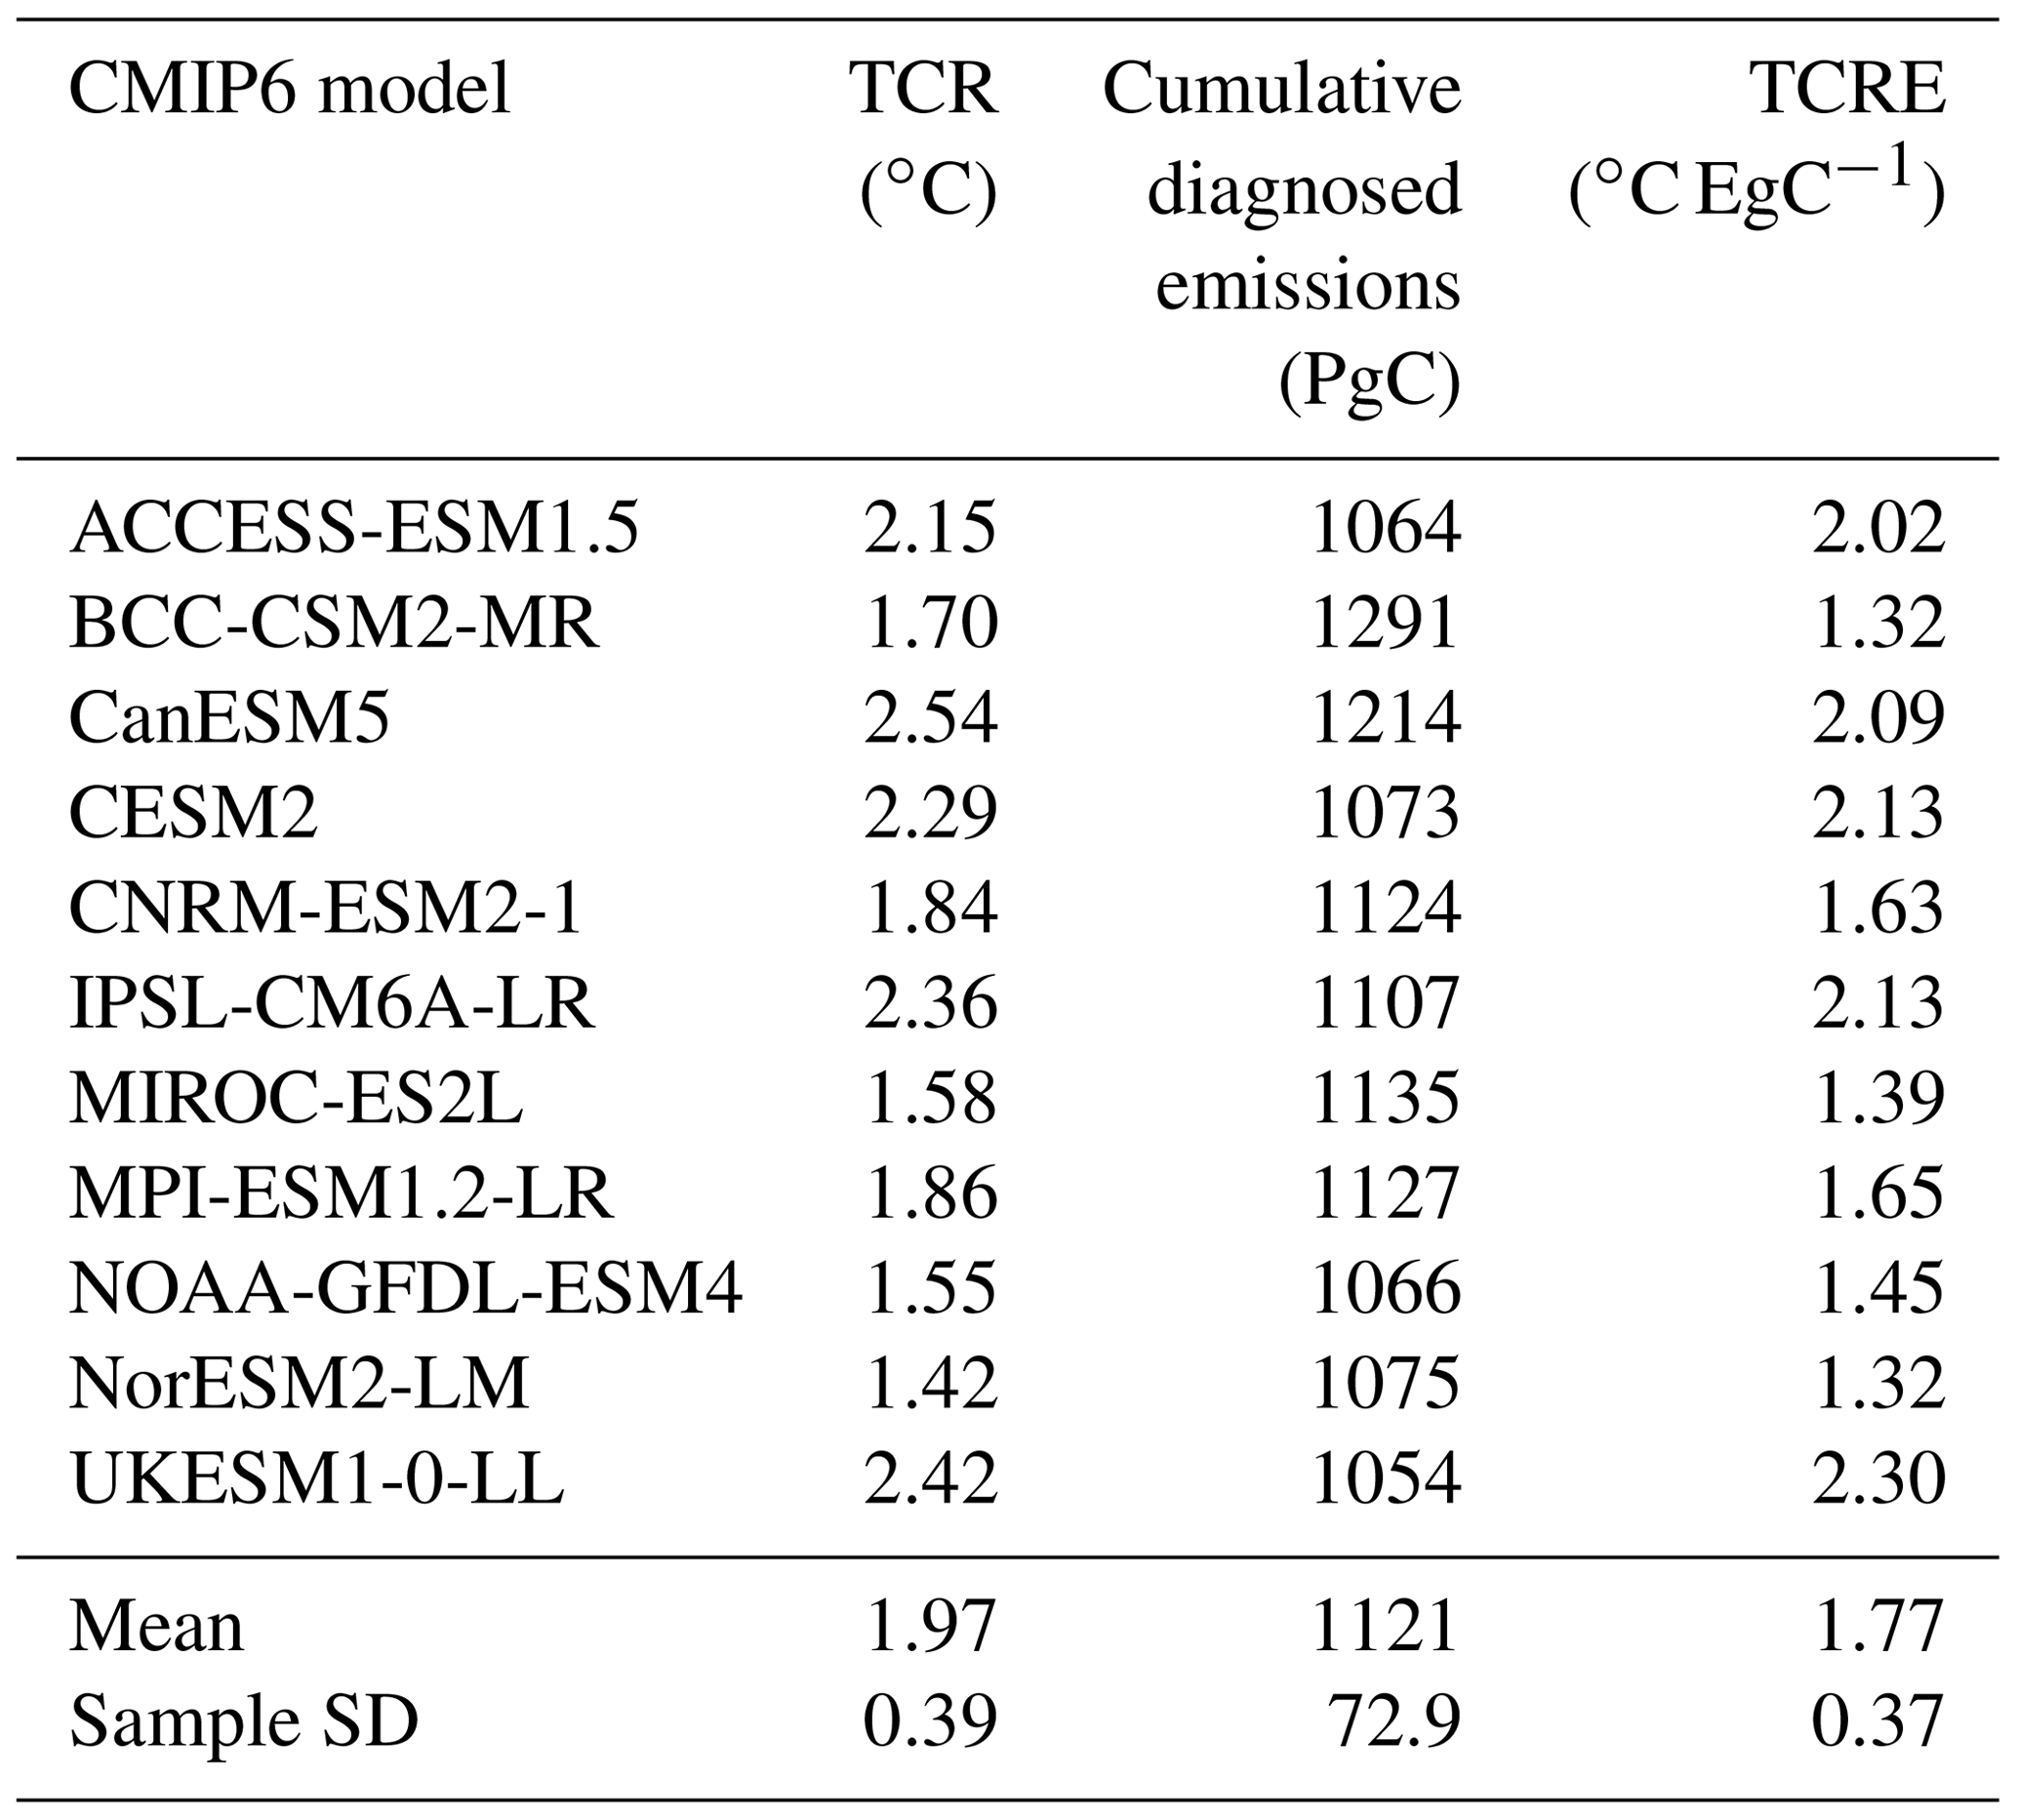

In [20]:
TCR_dict = {'NORESM2':1.42, 'GFDL':1.55, 'UKESM1_r1':2.42, 'MIROC': 1.58, 'ACCESS': 2.15, 'CANESM5_r1p2': 2.54}

In [21]:
e_dict = {'GFDL':1066, 'ACCESS':1064, 'CANESM5_r1p1': 1214, 'MIROC': 1135, 'UKESM1_r1': 1054, 'NORESM2':1075}

In [22]:
tcre_dict = {'GFDL':1.45, 'ACCESS':2.02, 'CANESM5_r1p1': 2.09, 'MIROC': 1.39, 'UKESM1_r1': 2.3, 'NORESM2':1.32}

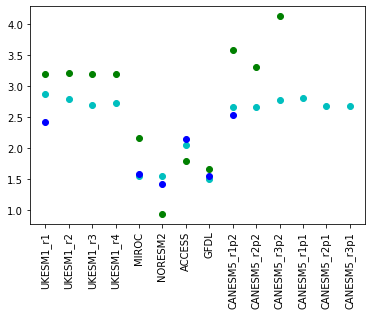

In [26]:
plt.plot(ds_dif['model'].values, ds_dif.sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'], 'co', label = 'Model')
for m in conv_1pct_mean.keys():
    plt.plot(m, conv_1pct_mean_ds.sel(model = m, pulse_type = 'pulse').sel(s = slice(60,80)).mean(dim = ['s']), 'go', label = 'Convolution')
plt.plot(TCR_dict.keys(), TCR_dict.values(), 'bo', label = 'Paper comparison')
plt.xticks(rotation = 90);


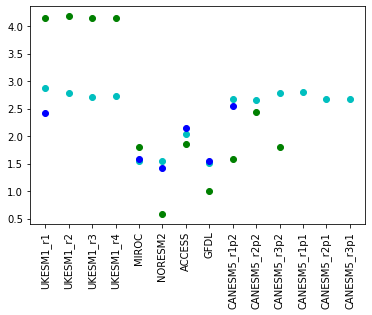

In [68]:
plt.plot(ds_dif['model'].values, ds_dif.sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'], 'co', label = 'Model')
for m in conv_1pct_mean.keys():
    plt.plot(m, conv_1pct_mean_ds.sel(model = m, pulse_type = 'cdr').sel(s = slice(60,80)).mean(dim = ['s']), 'go', label = 'Convolution')
plt.plot(TCR_dict.keys(), TCR_dict.values(), 'bo', label = 'Paper comparison')
plt.xticks(rotation = 90);


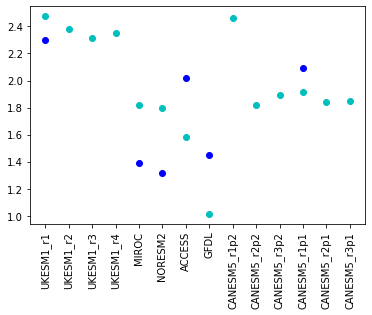

In [27]:
plt.plot(ds_dif['model'].values, 
         ds_dif.sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas']/(emis_profile.sel(year = slice(0,70)).sum(dim = 'year')['emis'].values/1000), 
         'co', label = 'Model')
plt.plot(tcre_dict.keys(), tcre_dict.values(), 'bo')
plt.xticks(rotation = 90);

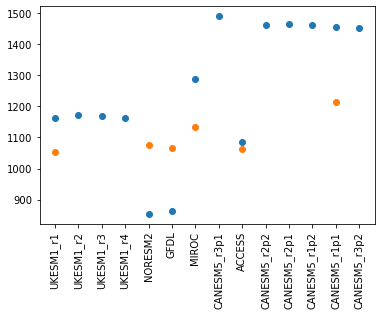

In [28]:
plt.plot(emis_profile.model, emis_profile.sel(year = slice(0,70)).sum(dim = 'year')['emis'].values, 'o')
plt.plot(e_dict.keys(), e_dict.values(), 'o')
plt.xticks(rotation = 90);

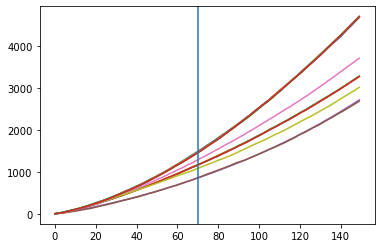

In [29]:
plt.plot(emis_profile.cumsum(dim = 'year')['emis'].transpose());
plt.axvline(70)

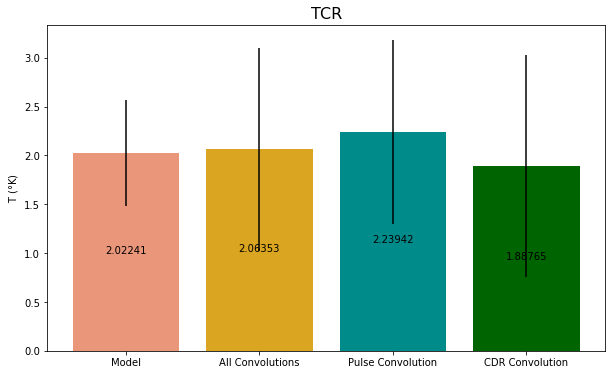

In [215]:
x = ['Model', 'All Convolutions', 'Pulse Convolution', 'CDR Convolution']
y = [ds_dif.sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].weighted(model_weights).mean(dim = 'model').values,
conv_1pct_mean_ds.sel(s = slice(60,80)).mean(dim = ['s']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').values,
conv_1pct_mean_ds.sel(pulse_type = 'pulse').sel(s = slice(60,80)).mean(dim = ['s']).weighted(model_weights).mean(dim = 'model').values,
conv_1pct_mean_ds.sel(pulse_type = 'cdr').sel(s = slice(60,80)).mean(dim = ['s']).weighted(model_weights).mean(dim = 'model').values]

num_std = 1
yerr = [num_std*ds_dif.sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].weighted(model_weights).std(dim = 'model').values,
num_std*conv_1pct_mean_ds.sel(s = slice(60,80)).mean(dim = ['s']).weighted(model_weights).std(dim = 'model').mean(dim = 'pulse_type').values,
num_std*conv_1pct_mean_ds.sel(pulse_type = 'pulse').sel(s = slice(60,80)).mean(dim = ['s']).weighted(model_weights).std(dim = 'model').values,
num_std*conv_1pct_mean_ds.sel(pulse_type = 'cdr').sel(s = slice(60,80)).mean(dim = ['s']).weighted(model_weights).std(dim = 'model').values]

fig, ax = plt.subplots(figsize = [10,6])
bars = plt.bar(x, y, color = type_color.values())
plt.bar_label(bars, label_type = 'center', padding = 2)
plt.ylabel('T ($\degree$K)')
for idx in np.arange(0,len(y)):
    idx_convert = {0:'model',1:'pulse',2:'cdr',3:'all'}
    plt.errorbar(x = x[idx], y = y[idx], yerr = yerr[idx], color = 'k')
plt.title("TCR", fontsize = 16)
plt.savefig('figures/1pct_increase/bar_plot_TCR.png', bbox_inches = 'tight', dpi = 300)

In [191]:

def reindex_df(df, weight_col):
    """expand the dataframe to prepare for resampling
    result is 1 row per count per sample"""
    df = df.reindex(df.index.repeat(df[weight_col]))
    df.reset_index(drop=True, inplace=True)
    return(df)


data = {'mean': conv_1pct_mean_ds.sel(pulse_type = 'pulse').sel(s = slice(60,80)).mean(dim = ['s']).values,
        'model': conv_1pct_mean_ds.model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 12, 4, 4, 4]}
df_pulse = pd.DataFrame(data)
df_pulse = reindex_df(df_pulse, weight_col = 'count')


data = {'mean': conv_1pct_mean_ds.sel(pulse_type = 'cdr').sel(s = slice(60,80)).mean(dim = ['s']).values,
        'model': conv_1pct_mean_ds.model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 12, 4, 4, 4]}
df_cdr = pd.DataFrame(data)
df_cdr = reindex_df(df_cdr, weight_col = 'count')


data = {'mean': ds_dif.where(ds_dif['model'].isin(model_weights.model.values), drop = True).sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].values,
        'model': ds_dif.where(ds_dif['model'].isin(model_weights.model.values), drop = True).model.values,
        'count': [3, 3, 3, 3, 12, 12, 12, 12, 4, 4, 4]}

df_model = pd.DataFrame(data)
df_model = reindex_df(df_model, weight_col = 'count')


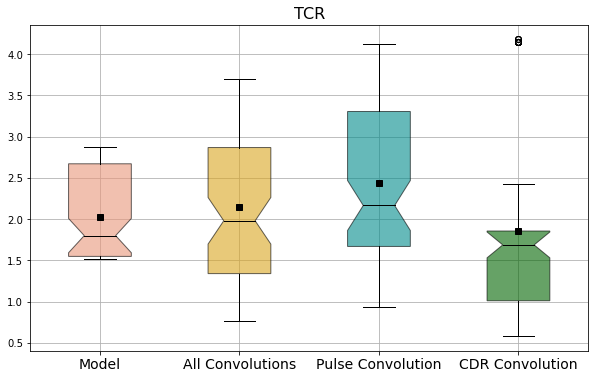

In [214]:
x = ['Model', 'All Convolutions', 'Pulse Convolution', 'CDR Convolution']
y = [df_model['mean'],
    (df_cdr + df_pulse)['mean']/2,
     df_pulse['mean'],
    df_cdr['mean']]
fig, ax = plt.subplots(figsize = [10,6])
box = plt.boxplot(y, showmeans= True, notch = True, patch_artist=True, meanprops={"marker":"s","markerfacecolor":"black", "markeredgecolor":"black"})
for patch, color in zip(box['boxes'], type_color.values()):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
for median in box['medians']:
    median.set_color('black')
plt.grid()
ax.set_xticklabels(x, fontsize = 14)
plt.title("TCR", fontsize = 16)
plt.savefig('figures/1pct_increase/TCR_boxplots.png', bbox_inches = 'tight', dpi = 300)

In [107]:
p = 'cdr'


In [108]:
print(conv_1pct_mean_ds.sel(pulse_type = p).sel(s = slice(60,80)).mean(dim = ['s']).where(
    (conv_1pct_mean_ds.sel(pulse_type = p).sel(s = slice(60,80)).mean(dim = ['s']) <
      (ds_dif.where(ds_dif['model'].isin(model_weights.model.values), drop = True).sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].weighted(model_weights).mean(dim = 'model') + 
       ds_dif.where(ds_dif['model'].isin(model_weights.model.values), drop = True).sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].weighted(model_weights).std(dim = 'model'))), drop = True)['model'])

<xarray.DataArray 'model' (model: 7)>
array(['NORESM2', 'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS',
       'CANESM5_r3p2'], dtype=object)
Coordinates:
    pulse_type  <U3 'cdr'
  * model       (model) object 'NORESM2' 'GFDL' ... 'ACCESS' 'CANESM5_r3p2'


In [109]:
print(conv_1pct_mean_ds.sel(pulse_type = p).sel(s = slice(60,80)).mean(dim = ['s']).where(
    (conv_1pct_mean_ds.sel(pulse_type = p).sel(s = slice(60,80)).mean(dim = ['s']) >
      (ds_dif.where(ds_dif['model'].isin(model_weights.model.values), drop = True).sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].weighted(model_weights).mean(dim = 'model') - 
       ds_dif.where(ds_dif['model'].isin(model_weights.model.values), drop = True).sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].weighted(model_weights).std(dim = 'model'))), drop = True)['model'])

<xarray.DataArray 'model' (model: 9)>
array(['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'MIROC',
       'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2'], dtype=object)
Coordinates:
    pulse_type  <U3 'cdr'
  * model       (model) object 'UKESM1_r1' 'UKESM1_r2' ... 'CANESM5_r3p2'


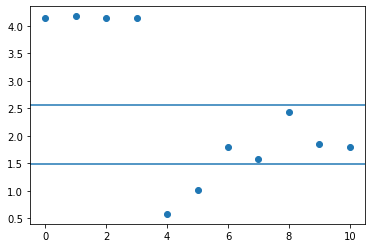

In [110]:
plt.plot(conv_1pct_mean_ds.sel(pulse_type = p).sel(s = slice(60,80)).mean(dim = ['s']), 'o')
plt.axhline((ds_dif.where(ds_dif['model'].isin(model_weights.model.values), drop = True).sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].weighted(model_weights).mean(dim = 'model') + 
       ds_dif.where(ds_dif['model'].isin(model_weights.model.values), drop = True).sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].weighted(model_weights).std(dim = 'model')))
plt.axhline((ds_dif.where(ds_dif['model'].isin(model_weights.model.values), drop = True).sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].weighted(model_weights).mean(dim = 'model') - 
       ds_dif.where(ds_dif['model'].isin(model_weights.model.values), drop = True).sel(s = slice(60,80)).weighted(A).mean(dim = ['s', 'lon','lat'])['tas'].weighted(model_weights).std(dim = 'model')))

In [137]:
pulse_good_models = ['GFDL', 'MIROC', 'ACCESS']
cdr_good_models = ['MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2']

## Spatial Analysis

In [17]:
%%time

GF = G_ds

conv_1pct = {}

for m1 in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2',
   'GFDL', 'MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2',]:
    conv_1pct[m1] = {}
    print(m1)
    for t in ['pulse','cdr']:
        if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
            m2 = 'UKESM1_r1'
        else:
            m2 = m1
        print(m1, m2)
        conv_1pct[m1][t] = signal.convolve(np.array(GF.sel(model = m2, pulse_type = t).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis'])[..., None, None],'full')
        conv_1pct[m1][t] = utils.np_to_xr(conv_1pct[m1][t], GF.sel(model = m2, pulse_type = t), emis_profile.sel(model = m1))


UKESM1_r1
UKESM1_r1 UKESM1_r1
UKESM1_r1 UKESM1_r1
UKESM1_r2
UKESM1_r2 UKESM1_r1
UKESM1_r2 UKESM1_r1
UKESM1_r3
UKESM1_r3 UKESM1_r1
UKESM1_r3 UKESM1_r1
UKESM1_r4
UKESM1_r4 UKESM1_r1
UKESM1_r4 UKESM1_r1
NORESM2
NORESM2 NORESM2
NORESM2 NORESM2
GFDL
GFDL GFDL
GFDL GFDL
MIROC
MIROC MIROC
MIROC MIROC
CANESM5_r1p2
CANESM5_r1p2 CANESM5_r1p2
CANESM5_r1p2 CANESM5_r1p2
CANESM5_r2p2
CANESM5_r2p2 CANESM5_r2p2
CANESM5_r2p2 CANESM5_r2p2
ACCESS
ACCESS ACCESS
ACCESS ACCESS
CANESM5_r3p2
CANESM5_r3p2 CANESM5_r3p2
CANESM5_r3p2 CANESM5_r3p2
CPU times: user 10.8 s, sys: 5.08 s, total: 15.9 s
Wall time: 16 s


In [18]:
#convert to dataset

conv_1pct_dict = {}
for m in conv_1pct.keys():
    conv_1pct_dict[m] = xr.concat([conv_1pct[m][t] for t in conv_1pct[m].keys()], pd.Index([t for t in conv_1pct[m].keys()], name='pulse_type'), coords='minimal')
    conv_1pct_ds = xr.concat([conv_1pct_dict[m] for m in conv_1pct_dict.keys()], pd.Index([m for m in conv_1pct_dict.keys()], name='model'), coords='minimal')


In [ ]:
## plot the trend over a given time period for all models
for t in [20,60]:
    for p in ['cdr','pulse']:
        fig, axes = plt.subplots(len(conv_1pct_ds.model), 3,figsize = [20,50], sharex = True, sharey = True, subplot_kw = {'projection':ccrs.PlateCarree()})
        vmin = -4
        vmax = 4
        for idx_m, m in enumerate(conv_1pct_ds.model.values):
            conv_1pct_ds.sel(model = m, pulse_type = p, s = slice(t-10, t+10)).mean(dim = 's').plot(ax = axes[idx_m, 0], vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
            axes[idx_m, 0].set_title(f'Convolution, {p}', fontsize = 14)
            axes[idx_m, 0].text(-0.08, 0.5, m, horizontalalignment='center', verticalalignment='center', rotation='vertical', transform=axes[idx_m, 0].transAxes, fontsize = 14)
            axes[idx_m, 0].coastlines()


            ds_dif.sel(model = m, s = slice(t-10, t+10)).mean(dim = 's')['tas'].plot(ax = axes[idx_m, 1], vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
            axes[idx_m, 1].set_title('1pct data', fontsize = 14)
            axes[idx_m, 1].coastlines()


            (conv_1pct_ds.sel(model = m, pulse_type = p) - ds_dif['tas'].sel(model = 'GFDL')).sel(s = slice(t-10, t+10)).mean(dim = 's').plot(ax = axes[idx_m, 2], vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
            axes[idx_m, 2].set_title('Difference', fontsize = 14)
            axes[idx_m, 2].coastlines()


            plt.suptitle(f'Annual trend to year {t}', fontsize = 16, x = .5, y = .99)
        plt.savefig(f'figures/1pct_increase/annual_trends_{p}_all_{t}.png', bbox_inches = 'tight', dpi = 300)
        plt.tight_layout()
        plt.close();


In [ ]:
    ## plot the trend over a given time period for all models, mean over pulse type
for t in [20,60]:
    fig, axes = plt.subplots(len(conv_1pct_ds.model), 3,figsize = [20,50], sharex = True, sharey = True, subplot_kw = {'projection':ccrs.PlateCarree()})
    vmin = -4
    vmax = 4
    for idx_m, m in enumerate(conv_1pct_ds.model.values):
        conv_1pct_ds.sel(model = m, s = slice(t-10, t+10)).mean(dim = ['s','pulse_type']).plot(ax = axes[idx_m, 0], vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
        axes[idx_m, 0].set_title(f'Convolution', fontsize = 14)
        axes[idx_m, 0].text(-0.08, 0.5, m, horizontalalignment='center', verticalalignment='center', rotation='vertical', transform=axes[idx_m, 0].transAxes, fontsize = 14)
        axes[idx_m, 0].coastlines()


        ds_dif.sel(model = m, s = slice(t-10, t+10)).mean(dim = 's')['tas'].plot(ax = axes[idx_m, 1], vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
        axes[idx_m, 1].set_title('1pct data', fontsize = 14)
        axes[idx_m, 1].coastlines()


        (conv_1pct_ds.sel(model = m) - ds_dif['tas'].sel(model = 'GFDL')).sel(s = slice(t-10, t+10)).mean(dim = ['s','pulse_type']).plot(ax = axes[idx_m, 2], vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
        axes[idx_m, 2].set_title('Difference', fontsize = 14)
        axes[idx_m, 2].coastlines()


        plt.suptitle(f'Annual trend to year {t}', fontsize = 16, x = .5, y = .99)
    plt.savefig(f'figures/1pct_increase/annual_trends_mean_pulse_type_all_{t}.png', bbox_inches = 'tight', dpi = 300)
    plt.tight_layout()
    plt.close();


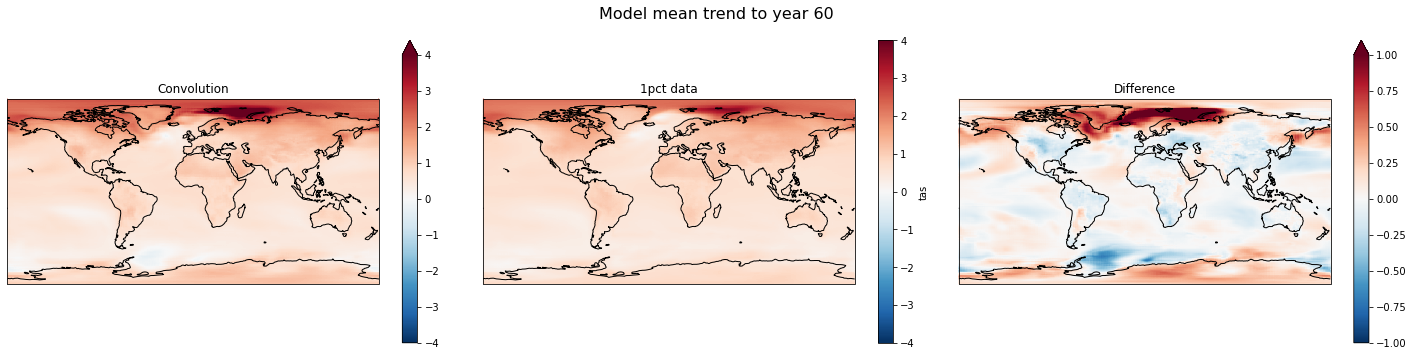

In [41]:
## plot the trend over a given time period for mean of models

for t in [20,60]:
    if t == 20:
        vmin = -1
        vmax = 1
    elif t == 60:
        vmin = -4
        vmax = 4
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5], subplot_kw = {'projection':ccrs.PlateCarree()})

    (conv_1pct_ds.weighted(model_weights).mean(dim = 'model').sel( s = slice(t-10, t+10)).mean(dim = 's')/t).mean(dim = 'pulse_type').plot(ax = ax1, 
                                                                                                                             vmax = vmax, vmin = vmin, cmap = 'RdBu_r', 
                                                                                                    cbar_kwargs = {'label':'$\Delta$T ($\degree$K yr$^-1$)'}, transform = ccrs.PlateCarree())
    ax1.set_title(f'Convolution')
    ax1.coastlines()

    (ds_dif.weighted(model_weights).mean(dim = 'model')['tas'].sel(s = slice(t-10, t+10)).mean(dim = 's')/t).plot(ax = ax2, 
                                                                                                        vmax = vmax, vmin = vmin, cmap = 'RdBu_r', 
                                                                                                    cbar_kwargs = {'label':'$\Delta$T ($\degree$K yr$^-1$)'}, transform = ccrs.PlateCarree())
    ax2.set_title('1pct data')
    ax2.coastlines()

    ((conv_1pct_ds - 
     ds_dif['tas']).weighted(model_weights).mean(dim = 'model').sel(s = slice(t-10, t+10)).mean(dim = 's').mean(dim = 'pulse_type')/t).plot(ax = ax3, 
                                                                                                        vmax = 1, vmin = -1, cmap = 'RdBu_r', 
                                                                                                    cbar_kwargs = {'label':'$\Delta$T ($\degree$K yr$^-1$)'}, transform = ccrs.PlateCarree())
    ax3.set_title('Difference')
    ax3.coastlines()

    plt.suptitle(f'Model mean trend to year {t}', fontsize = 16)

    plt.tight_layout()
    #plt.savefig(f'figures/1pct_increase/annual_trends_mean_{t}.png', bbox_inches = 'tight', dpi = 350)
#plt.close();

In [ ]:
    ## plot the value at a given year for all models
for t in [20,60]:
    for p in ['cdr','pulse']:
        fig, axes = plt.subplots(len(conv_1pct_ds.model), 3,figsize = [20,50], sharex = True, sharey = True, subplot_kw = {'projection':ccrs.PlateCarree()})
        vmin = -4
        vmax = 4
        for idx_m, m in enumerate(conv_1pct_ds.model.values):
            conv_1pct_ds.sel(model = m, pulse_type = p, s = t).plot(ax = axes[idx_m, 0], 
                                                                          vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
            axes[idx_m, 0].set_title(f'Convolution, {p}', fontsize = 14)
            axes[idx_m, 0].text(-0.08, 0.5, m, horizontalalignment='center', verticalalignment='center', rotation='vertical', transform=axes[idx_m, 0].transAxes, fontsize = 14)
            axes[idx_m, 0].coastlines()

            ds_dif.sel(model = m, s = t)['tas'].plot(ax = axes[idx_m, 1], 
                                                     vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
            axes[idx_m, 1].set_title('1pct data', fontsize = 14)
            axes[idx_m, 1].coastlines()

            (conv_1pct_ds.sel(model = m, pulse_type = p) - ds_dif['tas'].sel(model = 'GFDL')).sel(s = t).plot(ax = axes[idx_m, 2], 
                                                                                                                    vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
            axes[idx_m, 2].set_title('Difference', fontsize = 14)
            axes[idx_m, 2].coastlines()

        plt.suptitle(f'Year {t}', fontsize = 16, x = 0.5, y = 0.99)
        plt.tight_layout()
        plt.savefig(f'figures/1pct_increase/annual_{p}_all_{t}.png', bbox_inches = 'tight', dpi = 350)
        plt.close();

In [ ]:
## plot the value at a given year for all models
for t in [20,60]:
    fig, axes = plt.subplots(len(conv_1pct_ds.model), 3,figsize = [20,50], sharex = True, sharey = True, subplot_kw = {'projection':ccrs.PlateCarree()})
    vmin = -4
    vmax = 4
    for idx_m, m in enumerate(conv_1pct_ds.model.values):
        conv_1pct_ds.sel(model = m, s = t).mean(dim = ['pulse_type']).plot(ax = axes[idx_m, 0], vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
        axes[idx_m, 0].set_title(f'Convolution, {p}', fontsize = 14)
        axes[idx_m, 0].text(-0.08, 0.5, m, horizontalalignment='center', verticalalignment='center', rotation='vertical', transform=axes[idx_m, 0].transAxes, fontsize = 14)
        axes[idx_m, 0].coastlines()

        ds_dif.sel(model = m, s = t)['tas'].plot(ax = axes[idx_m, 1], 
                                                 vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
        axes[idx_m, 1].set_title('1pct data', fontsize = 14)
        axes[idx_m, 1].coastlines()

        (conv_1pct_ds.sel(model = m).mean(dim = ['pulse_type']) - ds_dif['tas'].sel(model = 'GFDL')).sel(s = t).plot(ax = axes[idx_m, 2], 
                                                                                                                vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
        axes[idx_m, 2].set_title('Difference', fontsize = 14)
        axes[idx_m, 2].coastlines()

    plt.suptitle(f'Year {t}', fontsize = 16, x = 0.5, y = 0.99)
    plt.tight_layout()
    plt.savefig(f'figures/1pct_increase/annual_mean_pulse_type_all_{t}.png', bbox_inches = 'tight', dpi = 350)
    plt.close();

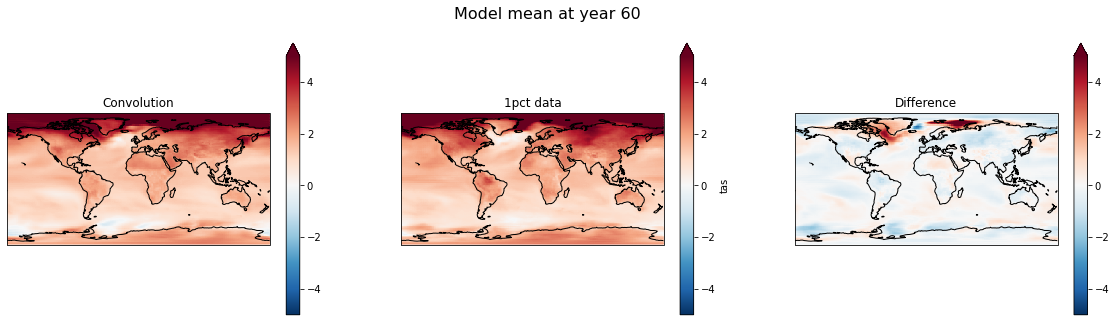

In [34]:
## plot the value at a given year for the mean
vmin = -2
vmax = 2
for t in [20,60]:
    if t == 20:
        vmin = -2
        vmax = 2
    elif t == 60:
        vmin = -5
        vmax = 5
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5], subplot_kw = {'projection':ccrs.PlateCarree()})

    conv_1pct_ds.weighted(model_weights).mean(dim = 'model').sel( s = t).mean(dim = 'pulse_type').plot(ax = ax1, 
                                                                                                vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
    ax1.set_title(f'Convolution')
    ax1.coastlines()

    ds_dif.weighted(model_weights).mean(dim = 'model')['tas'].sel(s = t).plot(ax = ax2, 
                                                                        vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
    ax2.set_title('1pct data')
    ax2.coastlines()

    (conv_1pct_ds - 
     ds_dif['tas']).weighted(model_weights).mean(dim = 'model').sel(s = t).mean(dim = 'pulse_type').plot(ax = ax3, 
                                                                            vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
    ax3.set_title('Difference')
    ax3.coastlines()

    plt.suptitle(f'Model mean at year {t}', fontsize = 16)
    plt.savefig(f'figures/1pct_increase/annual_mean_{t}.png', bbox_inches = 'tight', dpi = 350)
    #plt.close();

## Stipple plots

Stippling where the model mean convolution is greater than .5 of a standard deviation from the weighted model mean

In [118]:
num_std = .5

In [119]:
plus_std = ds_dif['tas'].weighted(model_weights).mean(dim = 'model') + num_std*ds_dif['tas'].weighted(model_weights).std(dim = 'model')
minus_std = ds_dif['tas'].weighted(model_weights).mean(dim = 'model') - num_std*ds_dif['tas'].weighted(model_weights).std(dim = 'model')
ds_compare = conv_1pct_ds.weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type')

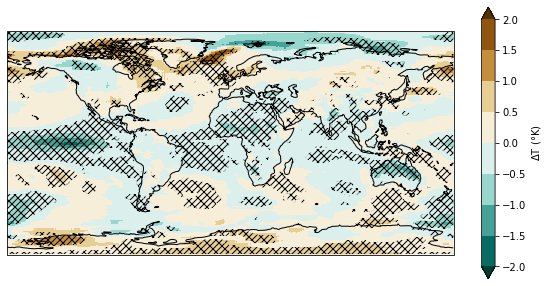

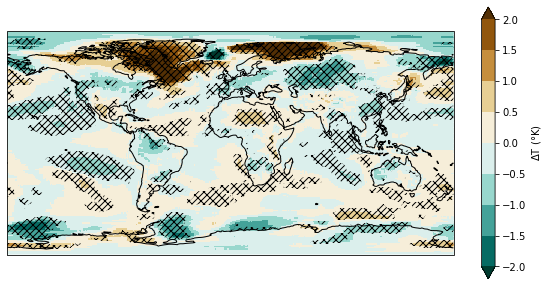

In [126]:
hatching = ((ds_compare > minus_std) & (ds_compare < plus_std))

cmap = mpl.cm.BrBG_r
levels = [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0]
for t in [20, 60]:
    vmin = -2
    vmax = 2
    fig, ax= plt.subplots(figsize = [10,5], subplot_kw = {'projection':ccrs.PlateCarree()})
    ##contours of convolution-1pct difference
    (conv_1pct_ds.weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type') -  ds_dif['tas'].weighted(model_weights).mean(dim = 'model')).sel(s = t).plot(ax = ax, 
                                                                                                                  cmap = cmap, levels = levels, 
                                                                                                                cbar_kwargs = {'label':'$\Delta$T ($\degree$K)'}, extend = 'both',
                                                                                                                transform = ccrs.PlateCarree())
    ##hatching for locations where convolution falls within 1std
    hatching.isel(s = t).plot.contourf(hatches = ['\\\\////', ''], levels = 3, colors = 'none', transform = ccrs.PlateCarree(), add_colorbar = False)
    ax.coastlines()
    plt.title('')
    plt.savefig(f'figures/1pct_increase/difference_{num_std}std_stippling_{t}.png', bbox_inches = 'tight', dpi = 300)

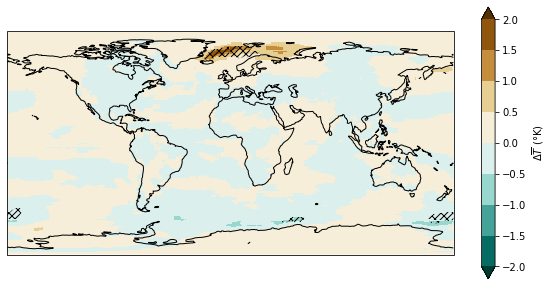

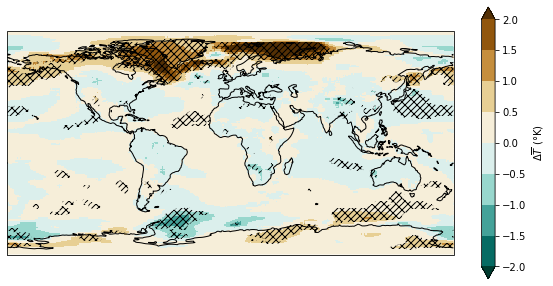

In [127]:
cmap = mpl.cm.BrBG_r
levels = [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0]
for t in [20,60]:
    vmin = -2
    vmax = 2
    fig, ax= plt.subplots(figsize = [10,5], subplot_kw = {'projection':ccrs.PlateCarree()})
    ##contours of convolution-1pct difference
    (conv_1pct_ds -  ds_dif['tas']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(t-10, t+10)).mean(dim = 's').plot(ax = ax, 
                                                                                                                  cmap = cmap, levels = levels, extend = 'both',
                                                                                                                cbar_kwargs = {'label':'$\Delta \overline{T}$ ($\degree$K)'},
                                                                                                                transform = ccrs.PlateCarree())
    hatching = ((ds_compare.sel(s = slice(t-10, t+10)).mean(dim = 's') > minus_std.sel(s = slice(t-10, t+10)).mean(dim = 's')) & 
                (ds_compare.sel(s = slice(t-10, t+10)).mean(dim = 's') < plus_std.sel(s = slice(t-10, t+10)).mean(dim = 's')))
    ##hatching for locations where convolution falls within 1std
    hatching.plot.contourf(hatches = ['\\\\////', ''], levels = 3, colors = 'none', transform = ccrs.PlateCarree(), add_colorbar = False)
    plt.title('')
    ax.coastlines()
    plt.savefig(f'figures/1pct_increase/difference_{num_std}std_stippling_mean_trend_{t}.png', bbox_inches = 'tight', dpi = 300)

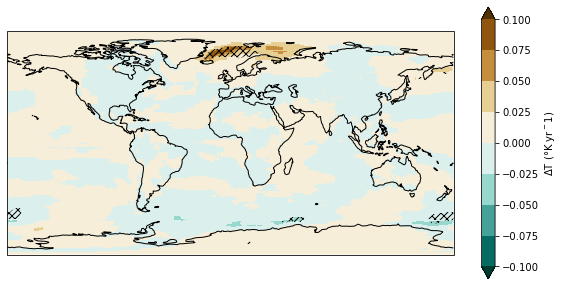

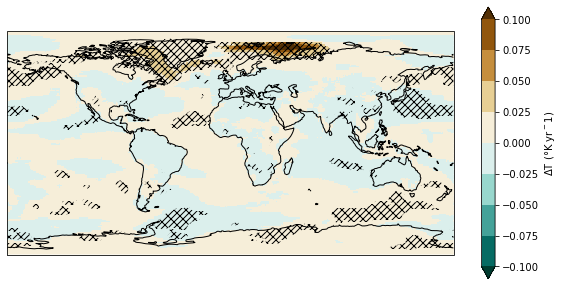

In [131]:
cmap = mpl.cm.BrBG_r
levels = np.arange(-.1,.125,.025)
for t in [20,60]:
    vmin = -2
    vmax = 2
    fig, ax= plt.subplots(figsize = [10,5], subplot_kw = {'projection':ccrs.PlateCarree()})
    ##contours of convolution-1pct difference
    ((conv_1pct_ds -  ds_dif['tas']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(t-10, t+10))/t).mean(dim = 's').plot(ax = ax, 
                                                                                                                  cmap = cmap, levels = levels, extend = 'both',
                                                                                                                cbar_kwargs = {'label':'$\Delta$T ($\degree$K yr$^-1$)'},
                                                                                                                transform = ccrs.PlateCarree())
    hatching = ((ds_compare.sel(s = slice(t-10, t+10)).mean(dim = 's')/t > minus_std.sel(s = slice(t-10, t+10)).mean(dim = 's')/t) & 
                (ds_compare.sel(s = slice(t-10, t+10)).mean(dim = 's')/t < plus_std.sel(s = slice(t-10, t+10)).mean(dim = 's')/t))
    ##hatching for locations where convolution falls within 1std
    hatching.plot.contourf(hatches = ['\\\\////', ''], levels = 3, colors = 'none', transform = ccrs.PlateCarree(), add_colorbar = False)
    plt.title('')
    ax.coastlines()
    plt.savefig(f'figures/1pct_increase/difference_{num_std}std_stippling_trend_{t}.png', bbox_inches = 'tight', dpi = 300)

## Spatial TCR

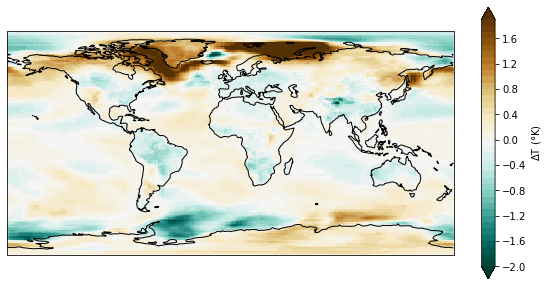

In [49]:
cmap = mpl.cm.BrBG_r
levels = np.arange(-2,2,.1)
vmin = -2
vmax = 2
fig, ax= plt.subplots(figsize = [10,5], subplot_kw = {'projection':ccrs.PlateCarree()})
##contours of convolution-1pct difference
(conv_1pct_ds -  ds_dif['tas']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(60, 80)).mean(dim = 's').plot(ax = ax, 
                                                                                                              cmap = cmap, levels = levels, extend = 'both',
                                                                                                            cbar_kwargs = {'label':'$\Delta$T ($\degree$K)'},
                                                                                                            transform = ccrs.PlateCarree())
ax.coastlines()
plt.savefig(f'figures/1pct_increase/difference_tcr_spatial.png', bbox_inches = 'tight', dpi = 300)

## Spatial Minus the Global Mean

In [ ]:

fig = plt.figure()
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0:2, :], projection=ccrs.PlateCarree())
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax1.coastlines(resolution='auto', color='k')
ax1.gridlines(color='lightgrey', linestyle='-', draw_labels=True)

ax2 = fig.add_subplot(gs[2, :])
ax2.plot([1, 2], [3, 4])

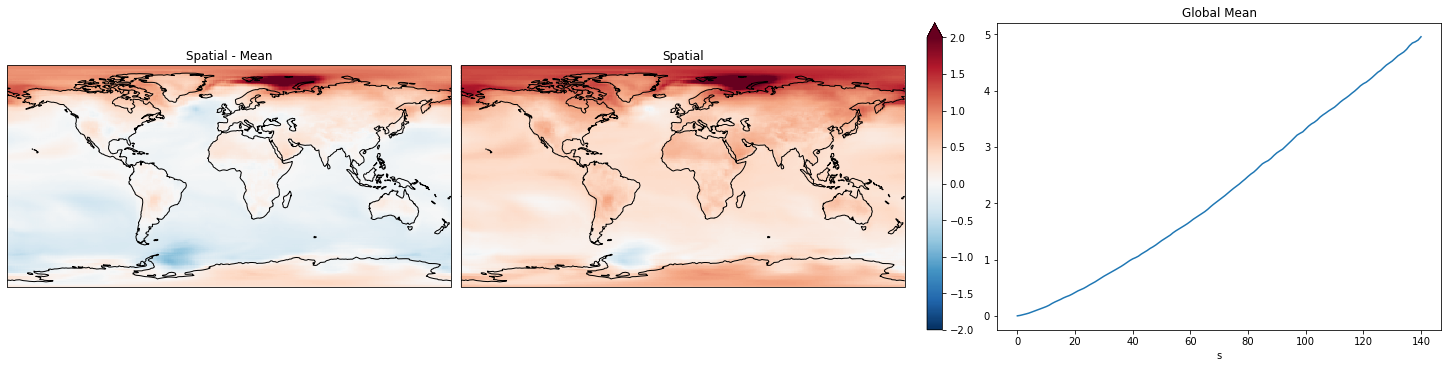

In [135]:
## plot the value at a given year for the mean
vmin = -2
vmax = 2
for t in [20]:
    fig = plt.figure(figsize = [20,5], constrained_layout = True)#, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5], subplot_kw = {'projection':ccrs.PlateCarree()})
        
    ax1 = fig.add_subplot(1,3,1, projection = ccrs.PlateCarree())
    (conv_1pct_ds-conv_1pct_mean_ds).weighted(model_weights).mean(dim = 'model').sel( s = t).mean(dim = 'pulse_type').plot(ax = ax1, 
                                                                                                vmax = vmax, vmin = vmin, cmap = 'RdBu_r', transform = ccrs.PlateCarree(), add_colorbar = False)
    ax1.set_title(f'Spatial - Mean')
    ax1.coastlines()

    ax2 = fig.add_subplot(1,3,2, projection = ccrs.PlateCarree())
    (conv_1pct_ds).weighted(model_weights).mean(dim = 'model').sel( s = t).mean(dim = 'pulse_type').plot(ax = ax2, 
                                                                        vmax = vmax, vmin = vmin, cmap = 'RdBu_r',
                                                                            cbar_kwargs = {'label':'$\Delta$T ($\degree$K)'},
                                                                                transform = ccrs.PlateCarree())
    ax2.set_title('Spatial')
    ax2.coastlines()

    ax3 = fig.add_subplot(1,3,3)
    conv_1pct_mean_ds.sel(s = slice(0,140)).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax3)
    ax3.set_title('Global Mean')
    #ax3.coastlines()

    #plt.suptitle(f'Model mean at year {t}', fontsize = 16)
    #plt.savefig(f'figures/1pct_increase/annual_mean_{t}.png', bbox_inches = 'tight', dpi = 350)
    #plt.close();

## Distribution of Difference

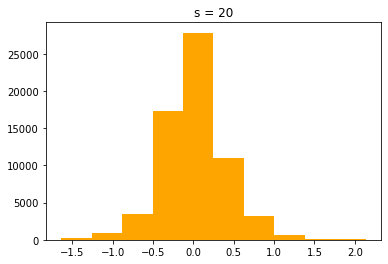

In [188]:
#plot the distribution of difference
((conv_1pct_ds - 
     ds_dif['tas']).weighted(model_weights).mean(dim = 'model').sel(s = t).mean(dim = 'pulse_type')).plot.hist(color = 'orange');

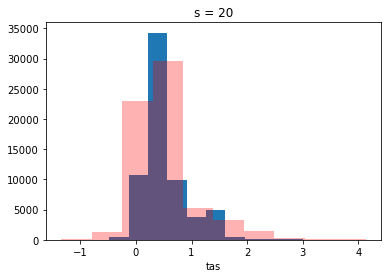

In [187]:
#plot the distribution of difference
conv_1pct_ds.weighted(model_weights).mean(dim = 'model').sel(s = t).mean(dim = 'pulse_type').plot.hist();
ds_dif['tas'].weighted(model_weights).mean(dim = 'model').sel(s = t).plot.hist(color = 'Red', alpha = 0.3);

(-1.0, 5.0)

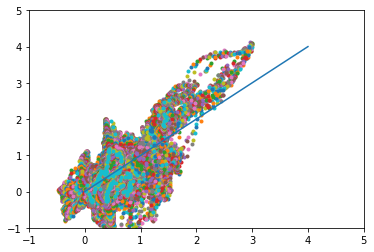

In [37]:
plt.plot(conv_1pct_ds.weighted(model_weights).mean(dim = 'model').sel(s = t).mean(dim = 'pulse_type'), 
    ds_dif['tas'].weighted(model_weights).mean(dim = 'model').sel(s = t), '.')
plt.plot(np.arange(0,5), np.arange(0,5))
plt.xlim(-1,5)
plt.ylim(-1,5)

## Recreate Lucarini plot

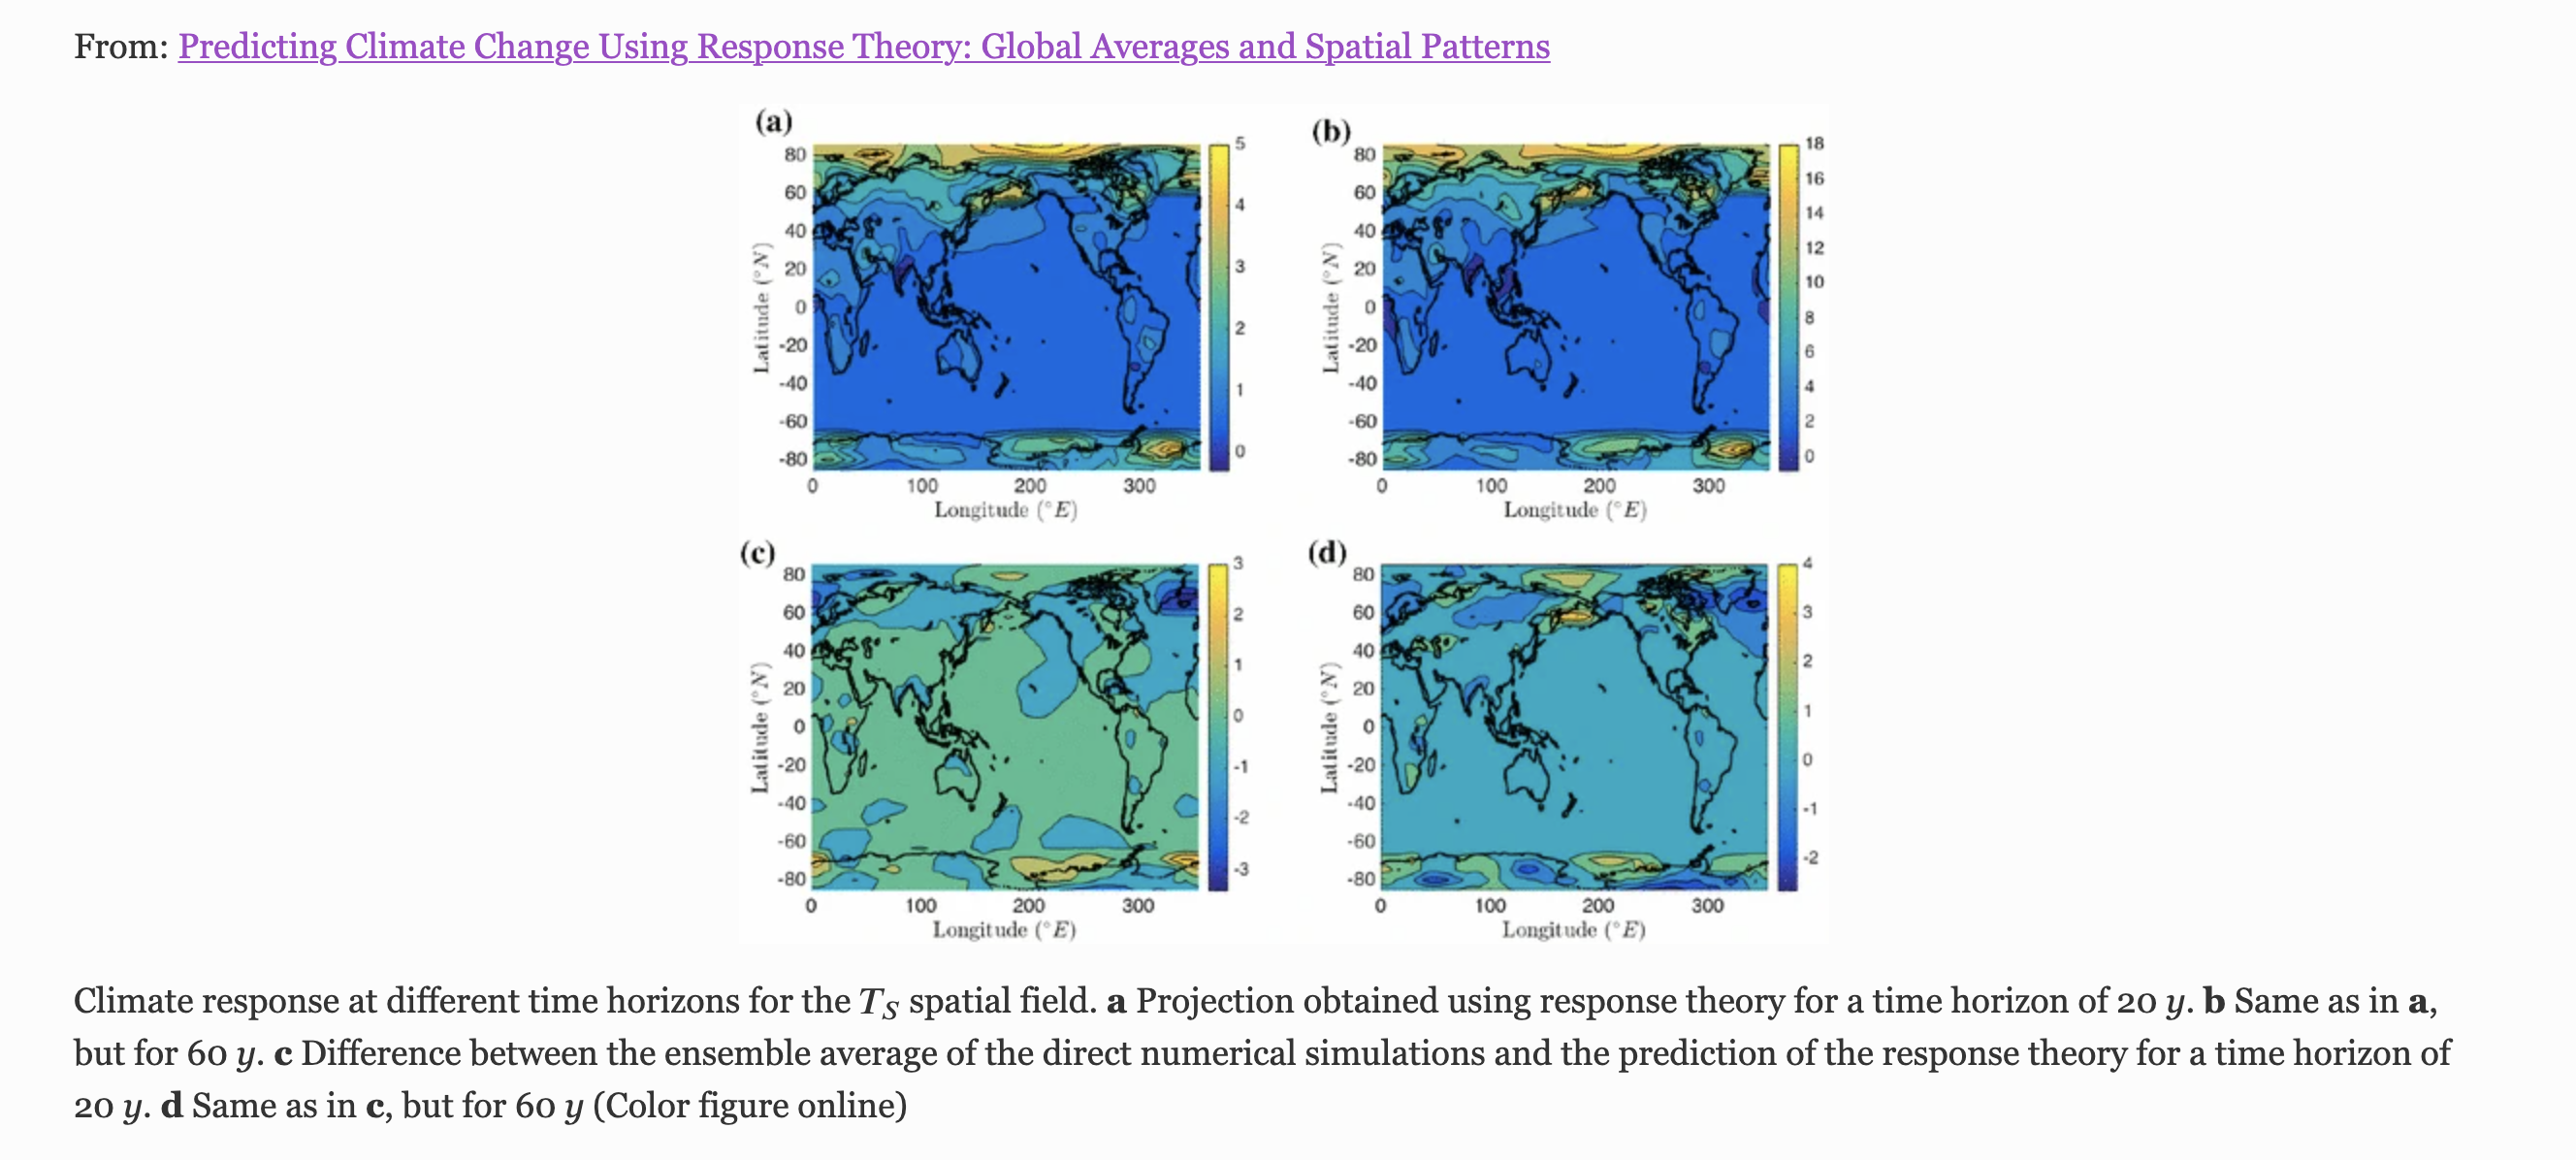

In [94]:
cmap = mpl.cm.viridis
bounds = [0,1,2,3,4,5,6]
norm = mpl.colors.BoundaryNorm(bounds, len(bounds) + 1, extend='both')


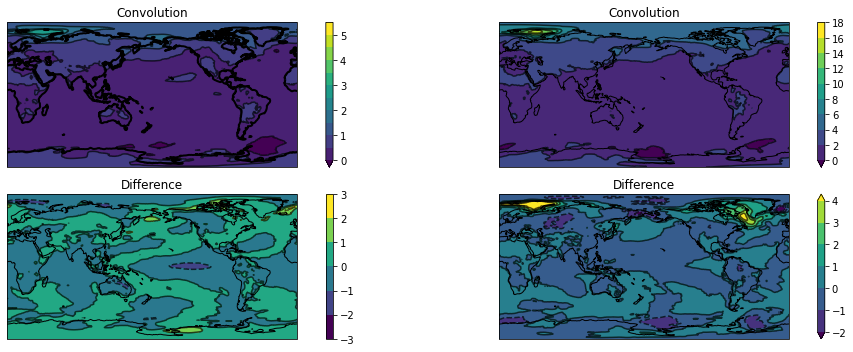

In [101]:
fig, axes = plt.subplots(2,2, figsize = [15,5], subplot_kw = {'projection':ccrs.PlateCarree(central_longitude=180)})
cmap = mpl.cm.viridis

t = 20
##twenty years convolution
ax1 = axes[0,0]

data = conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = t)
data.plot.contourf(ax = ax1, levels = np.arange(0,6,.5), cmap = cmap, transform = ccrs.PlateCarree())
data.plot.contour(ax = ax1, levels = np.arange(0,6,.5), colors = 'k', alpha = 0.7, transform = ccrs.PlateCarree())

ax1.set_title(f'Convolution')
ax1.coastlines(linewidth = 2)

##twenty years convolution-1pct
ax2 = axes[1,0]
data = (conv_1pct_ds.mean(dim = 'pulse_type') - ds_dif['tas']).weighted(model_weights).mean(dim = 'model').sel(s = t)
data.plot.contourf(ax = ax2, levels = np.arange(-3,4,1), cmap = cmap, transform = ccrs.PlateCarree())
data.plot.contour(ax = ax2, levels = np.arange(-3,4,1), colors = 'k', alpha = 0.7, transform = ccrs.PlateCarree())

ax2.set_title('Difference')
ax2.coastlines()

t = 60
##sixty years convolution
ax3 = axes[0,1]
data = conv_1pct_ds.weighted(model_weights).mean(dim = ['model','pulse_type']).sel(s = t)
data.plot.contourf(ax = ax3, levels = np.arange(0,20,2), cmap = cmap, transform = ccrs.PlateCarree())
data.plot.contour(ax = ax3, levels = np.arange(0,20,2), colors = 'k', alpha = 0.7,transform = ccrs.PlateCarree())

ax3.set_title(f'Convolution')
ax3.coastlines()

##sixty years convolution-1pct
ax4 = axes[1,1]
data = (conv_1pct_ds.mean(dim = 'pulse_type') - ds_dif['tas']).weighted(model_weights).mean(dim = 'model').sel(s = t)
data.plot.contourf(ax = ax4, levels = np.arange(-2,5,1), cmap = cmap, transform = ccrs.PlateCarree())
data.plot.contour(ax = ax4, levels = np.arange(-2,5,1), colors = 'k', alpha = 0.7, transform = ccrs.PlateCarree())

ax4.set_title('Difference')
ax4.coastlines()
plt.tight_layout()
plt.savefig(f'figures/1pct_increase/lucarini_comparison', bbox_inches = 'tight', dpi = 350)
#plt.close();

## Noise to signal ratio

According to: https://pure.mpg.de/rest/items/item_2566446_3/component/file_2566445/content

In [23]:
signal = conv_1pct_ds.weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type')
noise = conv_1pct_ds.weighted(model_weights).std(dim = 'model').mean(dim = 'pulse_type')
snr = np.abs(signal/noise)

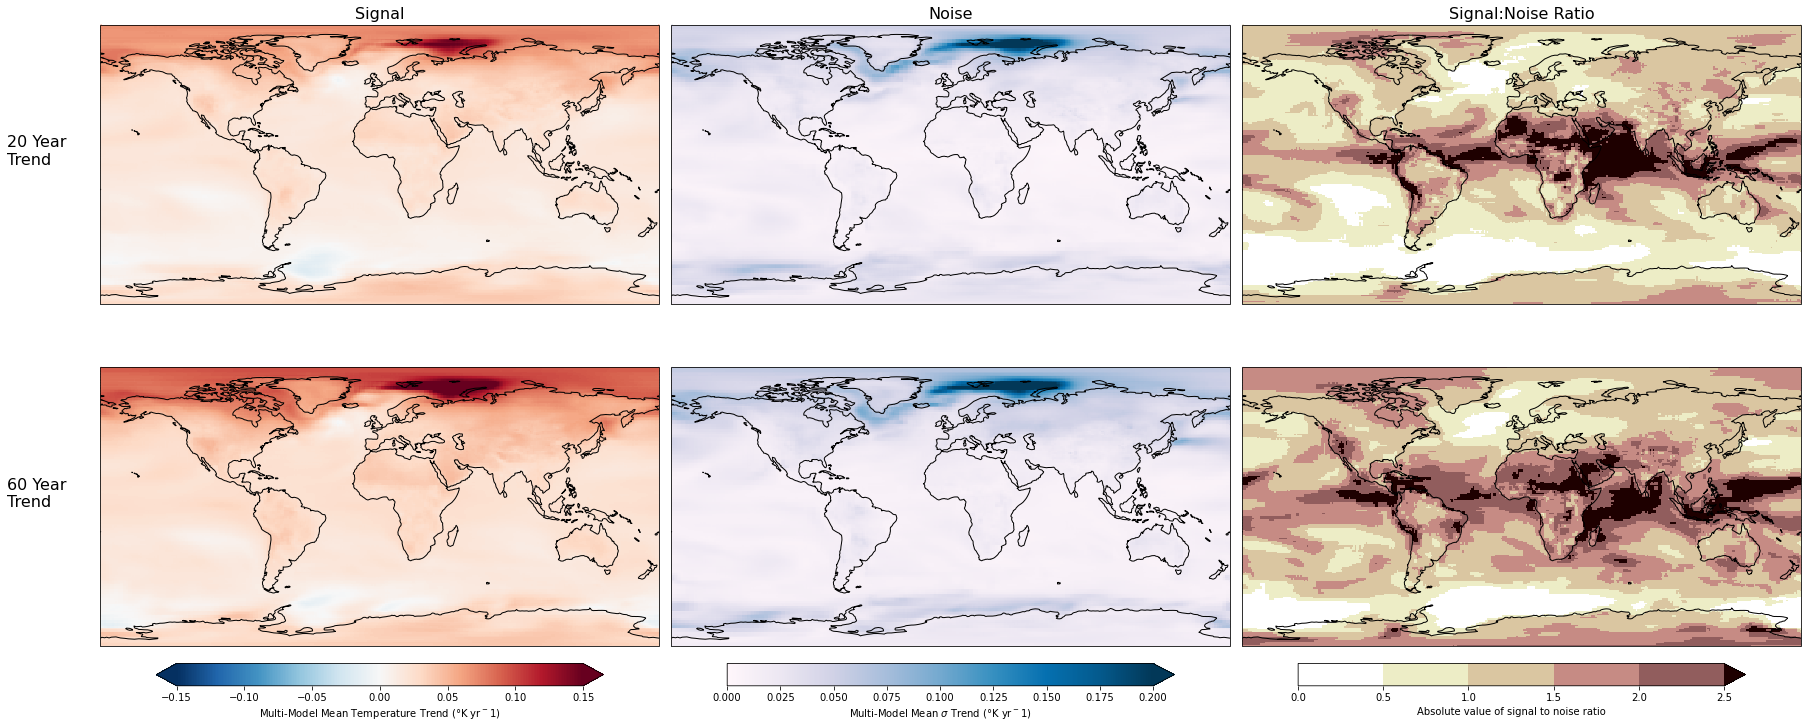

In [30]:
fig, axes = plt.subplots(2,3, figsize = [25,10], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)
for idx, t in enumerate([20,60]):
    cbar_arg = {0:None, 1:{'orientation':'horizontal','shrink':0.8, 'label':r'Multi-Model Mean Temperature Trend ($\degree$K yr$^-1$)'}}
    ax1 = axes[idx,0]
    (signal.sel(s = slice(t-10,t+10)).mean(dim = 's')/t).plot(ax = ax1,
        transform = ccrs.PlateCarree(), cmap = 'RdBu_r', vmin = -.15, vmax = .15, extend = 'both', add_colorbar = idx, cbar_kwargs= cbar_arg[idx])
    
    cbar_arg = {0:None, 1:{'orientation':'horizontal','shrink':0.8, 'label':'Multi-Model Mean $\sigma$ Trend ($\degree$K yr$^-1$)'}}
    ax2 = axes[idx, 1]
    (noise.sel(s = slice(t-10,t+10)).mean(dim = 's')/t).plot(ax = ax2,
        transform = ccrs.PlateCarree(), cmap = 'PuBu', vmin = 0, vmax = .2, add_colorbar = idx, cbar_kwargs= cbar_arg[idx])
    
    cbar_arg= {0:None, 1:{'orientation':'horizontal','shrink':0.8, 'label':'Absolute value of signal to noise ratio'}}
    ax3 = axes[idx,2]
    (snr.sel(s = slice(t-10,t+10)).mean(dim = 's')).plot(ax = ax3,
        transform = ccrs.PlateCarree(), levels = np.arange(0,3.,0.5), cmap = 'pink_r', add_colorbar = idx, cbar_kwargs= cbar_arg[idx] )
    
    ax1.coastlines()
    ax2.coastlines()
    ax3.coastlines()
    
    if idx == 0:
        ax1.set_title('Signal', fontsize = 16)
        ax2.set_title('Noise', fontsize = 16)
        ax3.set_title('Signal:Noise Ratio', fontsize = 16)

    ax1.text(x = -240, y = 0.1, s = f'{t} Year\nTrend', fontsize = 16)
plt.savefig(f'figures/1pct_increase/signal_to_noise_20_60_trend.png', bbox_inches = 'tight', dpi = 350)

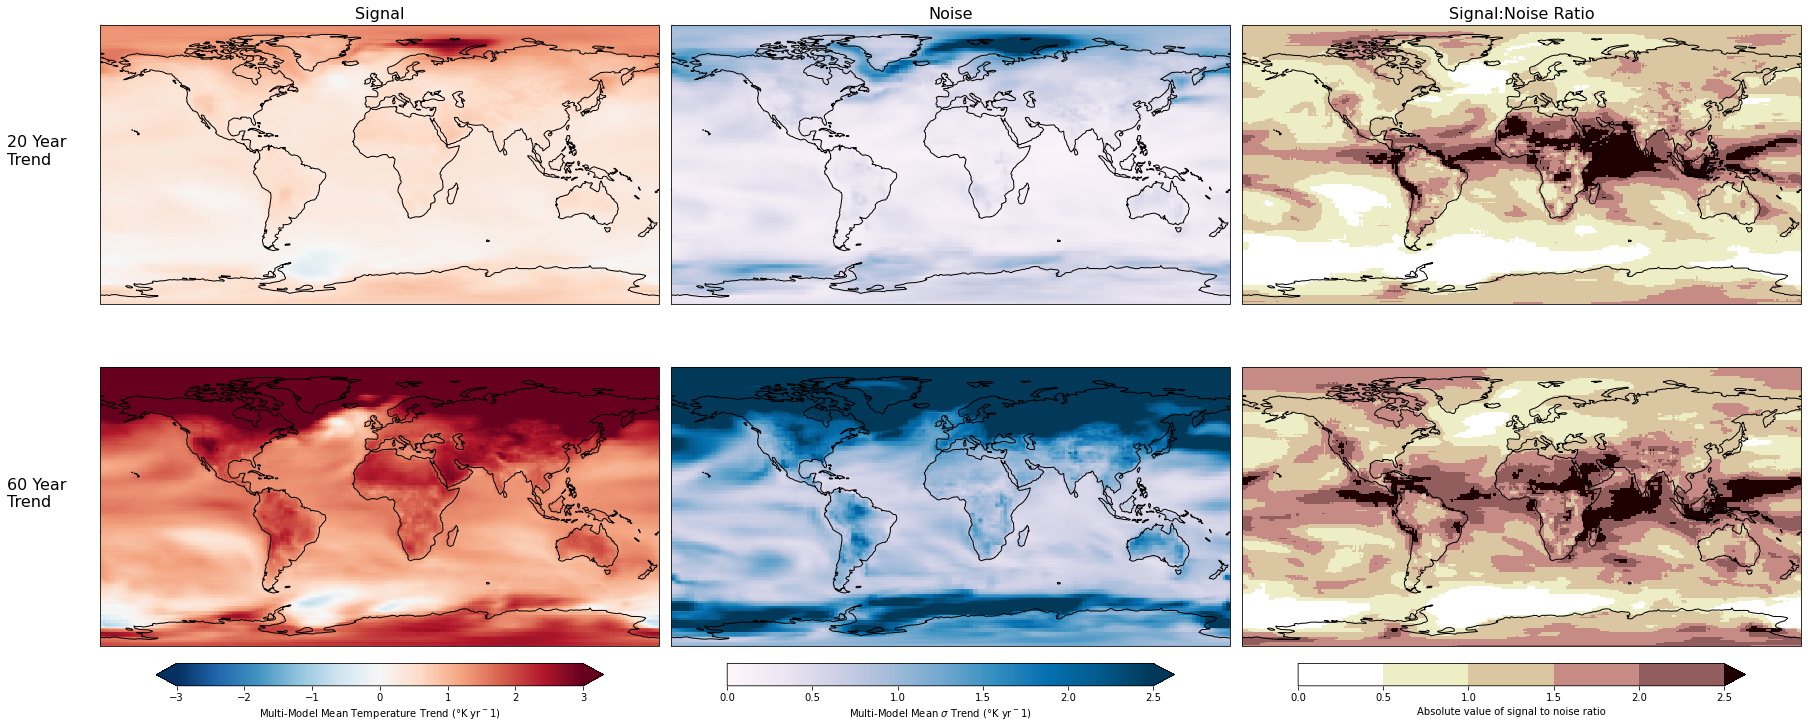

In [40]:
fig, axes = plt.subplots(2,3, figsize = [25,10], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)
for idx, t in enumerate([20,60]):
    cbar_arg = {0:None, 1:{'orientation':'horizontal','shrink':0.8, 'label':r'Multi-Model Mean Temperature Trend ($\degree$K yr$^-1$)'}}
    ax1 = axes[idx,0]
    (signal.sel(s = slice(t-10,t+10)).mean(dim = 's')).plot(ax = ax1,
        transform = ccrs.PlateCarree(), cmap = 'RdBu_r', vmin = -3., vmax = 3., extend = 'both', add_colorbar = idx, cbar_kwargs= cbar_arg[idx])
    
    cbar_arg = {0:None, 1:{'orientation':'horizontal','shrink':0.8, 'label':'Multi-Model Mean $\sigma$ Trend ($\degree$K yr$^-1$)'}}
    ax2 = axes[idx, 1]
    (noise.sel(s = slice(t-10,t+10)).mean(dim = 's')).plot(ax = ax2,
        transform = ccrs.PlateCarree(), cmap = 'PuBu', vmin = 0, vmax = 2.5, add_colorbar = idx, cbar_kwargs= cbar_arg[idx])
    
    cbar_arg= {0:None, 1:{'orientation':'horizontal','shrink':0.8, 'label':'Absolute value of signal to noise ratio'}}
    ax3 = axes[idx,2]
    (snr.sel(s = slice(t-10,t+10)).mean(dim = 's')).plot(ax = ax3,
        transform = ccrs.PlateCarree(), levels = np.arange(0,3.,0.5), cmap = 'pink_r', add_colorbar = idx, cbar_kwargs= cbar_arg[idx] )
    
    ax1.coastlines()
    ax2.coastlines()
    ax3.coastlines()
    
    if idx == 0:
        ax1.set_title('Signal', fontsize = 16)
        ax2.set_title('Noise', fontsize = 16)
        ax3.set_title('Signal:Noise Ratio', fontsize = 16)

    ax1.text(x = -240, y = 0.1, s = f'{t} Year\nTrend', fontsize = 16)
plt.savefig(f'figures/1pct_increase/signal_to_noise_20_60_mean_trend.png', bbox_inches = 'tight', dpi = 350)

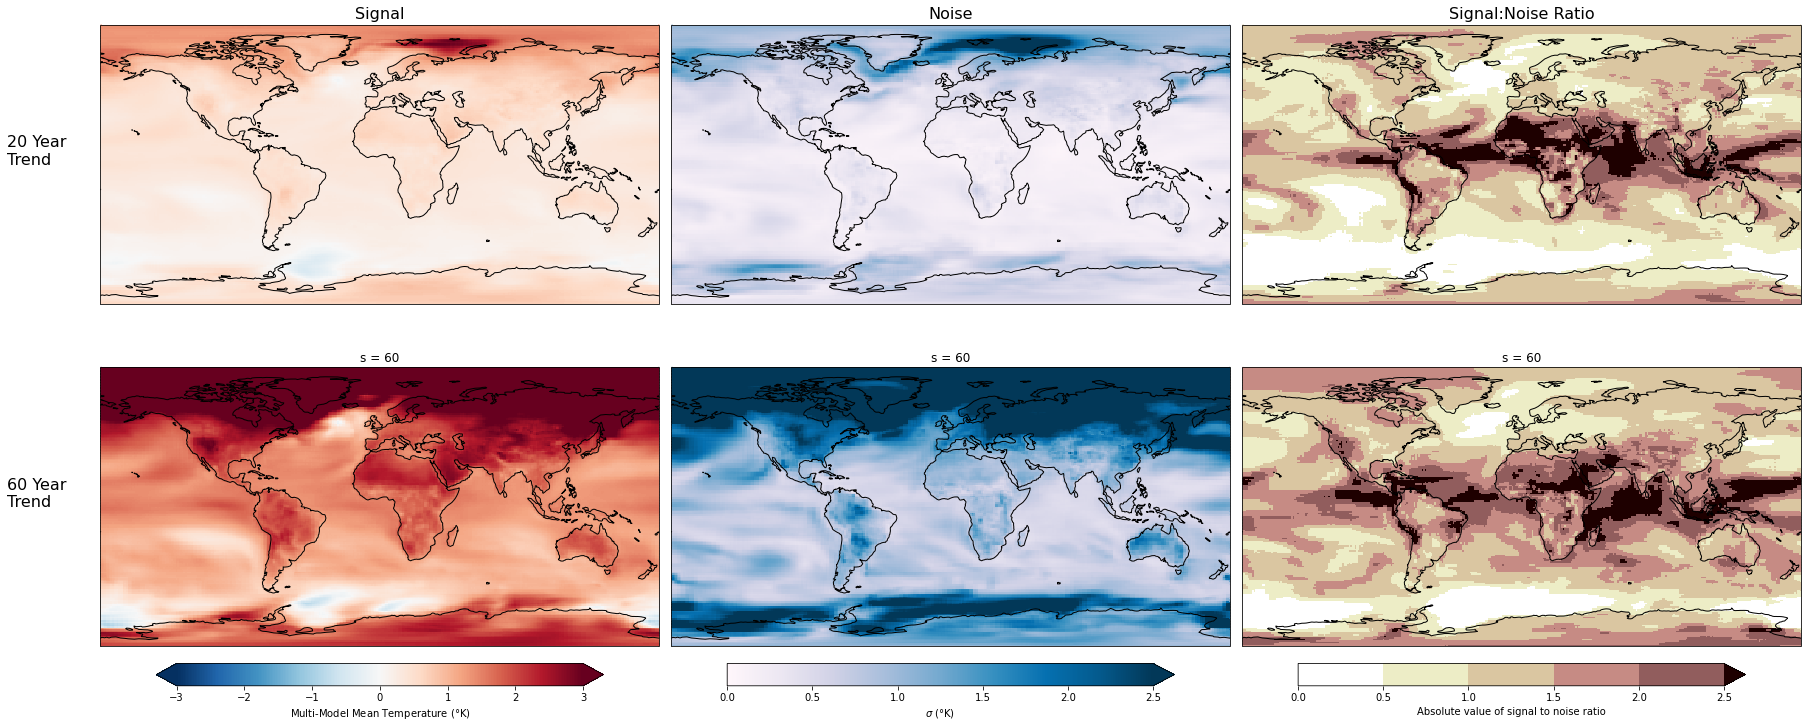

In [41]:
fig, axes = plt.subplots(2,3, figsize = [25,10], subplot_kw = {'projection':ccrs.PlateCarree()}, constrained_layout = True)
for idx, t in enumerate([20,60]):
    cbar_arg = {0:None, 1:{'orientation':'horizontal','shrink':0.8, 'label':r'Multi-Model Mean Temperature ($\degree$K)'}}
    ax1 = axes[idx,0]
    signal.sel(s = t).plot(ax = ax1,
        transform = ccrs.PlateCarree(), cmap = 'RdBu_r', vmin = -3., vmax = 3., extend = 'both', add_colorbar = idx, cbar_kwargs= cbar_arg[idx])
    
    cbar_arg = {0:None, 1:{'orientation':'horizontal','shrink':0.8, 'label':'$\sigma$ ($\degree$K)'}}
    ax2 = axes[idx, 1]
    noise.sel(s = t).plot(ax = ax2,
        transform = ccrs.PlateCarree(), cmap = 'PuBu', vmin = 0, vmax = 2.5, add_colorbar = idx, cbar_kwargs= cbar_arg[idx])
    
    cbar_arg= {0:None, 1:{'orientation':'horizontal','shrink':0.8, 'label':'Absolute value of signal to noise ratio'}}
    ax3 = axes[idx,2]
    snr.sel(s = t).plot(ax = ax3,
        transform = ccrs.PlateCarree(), levels = np.arange(0,3.,0.5), cmap = 'pink_r', add_colorbar = idx, cbar_kwargs= cbar_arg[idx] )
    
    ax1.coastlines()
    ax2.coastlines()
    ax3.coastlines()
    
    if idx == 0:
        ax1.set_title('Signal', fontsize = 16)
        ax2.set_title('Noise', fontsize = 16)
        ax3.set_title('Signal:Noise Ratio', fontsize = 16)

    ax1.text(x = -240, y = 0.1, s = f'{t} Year\nTrend', fontsize = 16)
plt.savefig(f'figures/1pct_increase/signal_to_noise_20_60.png', bbox_inches = 'tight', dpi = 350)

## Spatial runs only with the models that do well at the global mean

In [140]:
%%time

GF = G_ds

conv_1pct_lim = {}

for m in ['MIROC', 'CANESM5_r1p2', 'CANESM5_r2p2', 'ACCESS', 'CANESM5_r3p2', 'GFDL']:
    conv_1pct_lim[m] = {}
for m1 in pulse_good_models:
    print(m1)
    for t in ['pulse']:
        if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
            m2 = 'UKESM1_r1'
        else:
            m2 = m1
        print(m1, m2)
        conv_1pct_lim[m1][t] = signal.convolve(np.array(GF.sel(model = m2, pulse_type = t).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis'])[..., None, None],'full')
        conv_1pct_lim[m1][t] = utils.np_to_xr(conv_1pct_lim[m1][t], GF.sel(model = m2, pulse_type = t), emis_profile.sel(model = m1))


for m1 in cdr_good_models:
    print(m1)
    for t in ['cdr']:
        if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
            m2 = 'UKESM1_r1'
        else:
            m2 = m1
        print(m1, m2)
        conv_1pct_lim[m1][t] = signal.convolve(np.array(GF.sel(model = m2, pulse_type = t).dropna(dim = 's')), np.array(emis_profile.sel(model = m1)['emis'])[..., None, None],'full')
        conv_1pct_lim[m1][t] = utils.np_to_xr(conv_1pct_lim[m1][t], GF.sel(model = m2, pulse_type = t), emis_profile.sel(model = m1))


GFDL
GFDL GFDL
MIROC
MIROC MIROC
ACCESS
ACCESS ACCESS
MIROC
MIROC MIROC
CANESM5_r1p2
CANESM5_r1p2 CANESM5_r1p2
CANESM5_r2p2
CANESM5_r2p2 CANESM5_r2p2
ACCESS
ACCESS ACCESS
CANESM5_r3p2
CANESM5_r3p2 CANESM5_r3p2
CPU times: user 7.23 s, sys: 26.3 s, total: 33.5 s
Wall time: 34.7 s


In [141]:
#convert to dataset

conv_1pct_lim_dict = {}
for m in conv_1pct_lim.keys():
    conv_1pct_lim_dict[m] = xr.concat([conv_1pct_lim[m][t] for t in conv_1pct_lim[m].keys()], pd.Index([t for t in conv_1pct_lim[m].keys()], name='pulse_type'), coords='minimal')
    conv_1pct_lim_ds = xr.concat([conv_1pct_lim_dict[m] for m in conv_1pct_lim_dict.keys()], pd.Index([m for m in conv_1pct_lim_dict.keys()], name='model'), coords='minimal')


In [53]:
cmap = mpl.cm.BrBG_r
bounds = [-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0,2.5]
norm = mpl.colors.BoundaryNorm(bounds, len(bounds) + 1, extend='both')


In [54]:
p  = 'pulse'
test = ds_dif['tas'].weighted(model_weights).mean(dim = 'model').where((
    ds_dif['tas'].weighted(model_weights).mean(dim = 'model') < 
    conv_1pct_lim_ds.sel(pulse_type = p).weighted(model_weights).mean(dim = 'model') + conv_1pct_lim_ds.sel(pulse_type = p).weighted(model_weights).std(dim = 'model')) | 
    (ds_dif['tas'].weighted(model_weights).mean(dim = 'model') > 
    conv_1pct_lim_ds.sel(pulse_type = p).weighted(model_weights).mean(dim = 'model') - conv_1pct_lim_ds.sel(pulse_type = p).weighted(model_weights).std(dim = 'model')),
    drop = True)


vmin = -2
vmax = 2

fig, ax= plt.subplots(figsize = [10,5], subplot_kw = {'projection':ccrs.PlateCarree()})
(conv_1pct_lim_ds.sel(pulse_type = p) - 
         ds_dif['tas']).weighted(model_weights).mean(dim = 'model').sel(s = slice(t-10, t+10)).mean(dim = 's').plot(ax = ax, 
                                                                                                            vmax = vmax, vmin = vmin, 
                                                                                                              cmap = 'Dark2', transform = ccrs.PlateCarree())
ax.contourf(test.isel(s = 20)['lon'], test.isel(s = 20)['lat'], test.sel(s = slice(t-10, t+10)).mean(dim = 's').values, hatches = ['\\\///',None],colors='none', transform = ccrs.PlateCarree())
ax.coastlines()

NameError: name 'conv_1pct_lim_ds' is not defined